# <font color="orange"><font size="7"> **NOTEBOOK INTERACTIVO PARA LA EXPLORACIÓN DE MODELOS DE DEEP LEARNING**

<font color="orange">**Trabajo Final de Máster** - Desarrollo de un modelo de clasificación de enfermedades en hojas de múltiples especies de planta mediante PlantCV y modelos de aprendizaje profundo
---
<font color="orange">**Autor:** Marco Tulio Paredes Fajardo

<font color="orange">Este notebook está diseñado para explorar y optimizar 3 modelos de deep learning que sean capaces de clasificar enfermedades de hojas de planta provenientes de imágenes de laboratorio y de campo.

<font color="orange">**Modelos de DL:** EfficientNetB0, ResNet50, MobileNetV2

<font color="orange"><font size="2.5">*(Código generado con ayuda de ChatGPT)*

In [ ]:
# Establecer semilla para el notebook
import random, numpy as np, tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# <font color="orange"><font size="7"> **1.- Configuración Google Drive**

## <font color="orange"><font size="5"> **1.1.- Montar Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color="orange"><font size="5"> **1.2.- Indicar rutas al Drive**

### <font color="orange"><font size="4"> ***1.2.1.- Rutas para imágenes segmentadas***

In [ ]:
# Ruta base del proyecto
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning"

# Ruta al excel de metadatos
METADATA_PATH = f"{BASE_PATH}/metadata_sin_blight_spot_seg_ex2.xlsx"

# Ruta del dataset comprimido
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/dataset_sin_blight_spot_seg_ex2.zip"

### <font color="orange"><font size="4"> ***1.2.2.- Rutas para imágenes no segmentadas***

In [ ]:
# Ruta al excel de metadatos
METADATA_PATH_no_seg = f"{BASE_PATH}/metadata_sin_blight_spot_no_seg_ex2.xlsx"

# Ruta del dataset comprimido
ZIP_PATH_no_seg = "/content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/dataset_sin_blight_spot_no_seg_ex2.zip"

##  <font color="orange"><font size="5"> **1.3.- Descomprimir dataset y carpeta de resultados**

### <font color="orange"><font size="4"> ***1.3.1.- Para imágenes segmentadas***

In [ ]:
# Librerías
import os

# Descomprimir imágenes segmentadas (.ZIP) desde el Drive al almacenamiento local de Colab
DST_PATH = "/content/dataset"

if not os.path.exists(DST_PATH):
    print("Descomprimiendo imágenes segmentadas desde Drive...")
    !unzip -q "$ZIP_PATH" -d /content/dataset
    print("Descompresión completada.")
else:
    print("Las imágenes segmentadas ya están disponibles en /content/dataset/")

# Ruta local de las imágenes del dataset
IMAGES_PATH = f"{DST_PATH}"
print(f"Nueva ruta de imágenes segmentadas: {IMAGES_PATH}/")

# Carpeta de resultados
RESULTS_PATH = os.path.join(BASE_PATH, "results_seg")
os.makedirs(RESULTS_PATH, exist_ok=True)

# Mostrar resultado
print("\nDrive montado correctamente.")
print(f"Ruta base: {BASE_PATH}")
print(f"Ruta de resultados: {RESULTS_PATH}")

Descomprimiendo imágenes segmentadas desde Drive...
Descompresión completada.
Nueva ruta de imágenes segmentadas: /content/dataset/

Drive montado correctamente.
Ruta base: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning
Ruta de resultados: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg


### <font color="orange"><font size="4"> ***1.3.2.- Para imágenes no segmentadas***

In [ ]:
# Descomprimir imágenes no segmentadas (.ZIP) desde el Drive al almacenamiento local de Colab
DST_PATH_no_seg = "/content/dataset_no_seg"

if not os.path.exists(DST_PATH_no_seg):
    print("Descomprimiendo imágenes NO segmentadas desde Drive...")
    !unzip -q "$ZIP_PATH_no_seg" -d /content/dataset_no_seg
    print("Descompresión completada.")
else:
    print("Las imágenes NO segmentadas ya están disponibles en /content/dataset_no_seg/")

# Ruta local de las imágenes del dataset
IMAGES_PATH_no_seg = f"{DST_PATH_no_seg}"
print(f"Nueva ruta de imágenes NO segmentadas: {IMAGES_PATH_no_seg}/")

# Carpeta de resultados
RESULTS_PATH_no_seg = os.path.join(BASE_PATH, "results_no_seg")
os.makedirs(RESULTS_PATH_no_seg, exist_ok=True)

# Mostrar resultado
print("\nDrive montado correctamente.")
print(f"Ruta base: {BASE_PATH}")
print(f"Ruta de resultados: {RESULTS_PATH_no_seg}")

Descomprimiendo imágenes NO segmentadas desde Drive...
Descompresión completada.
Nueva ruta de imágenes NO segmentadas: /content/dataset_no_seg/

Drive montado correctamente.
Ruta base: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning
Ruta de resultados: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg


#  <font color="orange"><font size="7"> **2.- Cargar metadatos y preparar rutas**

##  <font color="orange"><font size="5"> **2.1.- Para imágenes segmentadas**

In [ ]:
# Librerías
import os
import pandas as pd

# Cargar el Excel con los metadatos
metadata = pd.read_excel(METADATA_PATH)
print("Metadata cargada correctamente.")
print("Filas totales:", len(metadata))
metadata.head()

# Normalizr extensiones y nombres
metadata['image_name_new'] = metadata['image_name_new'].astype(str).str.replace('.JPG', '.jpg', regex=False)

# Función para obtener la ruta completa de cada imagen segmentada
def build_image_path(row):
    plant = row['plant']
    domain = row['domain']
    class_name = row['class']
    image_name = row['image_name_new']
    return os.path.join(IMAGES_PATH, plant, domain, class_name, image_name)

metadata['full_path'] = metadata.apply(build_image_path, axis=1)

# Filtrar conjuntos de train/val/test
train_lab = metadata[metadata['splits'] == 'train']
val_lab   = metadata[metadata['splits'] == 'val']
test_lab  = metadata[metadata['splits'] == 'test_in_domain']
test_field_species = metadata[metadata['splits'] == 'test_ood_species']
test_field_tomato = metadata[metadata['splits'] == 'test_ood_domain']

print("\n-------------------División del dataset-------------------")
print("Imágenes de laboratorio:")
print("> Train (tomato lab+field images):", len(train_lab))
print("> Val (tomato lab images):", len(val_lab))
print("> Test In-Domain (tomato lab images):", len(test_lab))
print("\nImágenes de campo:")
print("> Test Out-Domain (tomato field images):", len(test_field_tomato))
print("> Test Out-Domain (other plants field images):", len(test_field_species))


print("\n-----------Distribución de imágenes por dominio-----------")
print(metadata['domain'].value_counts())

print("\n-----------Distribución de imágenes por planta-----------")
print(metadata['plant'].value_counts())

print("\n-----------Distribución de imágenes por clase-----------")
print(metadata['class'].value_counts())

Metadata cargada correctamente.
Filas totales: 6000

-------------------División del dataset-------------------
Imágenes de laboratorio:
> Train (tomato lab+field images): 3150
> Val (tomato lab images): 675
> Test In-Domain (tomato lab images): 675

Imágenes de campo:
> Test Out-Domain (tomato field images): 300
> Test Out-Domain (other plants field images): 1200

-----------Distribución de imágenes por dominio-----------
domain
lab      4500
field    1500
Name: count, dtype: int64

-----------Distribución de imágenes por planta-----------
plant
tomato         4800
bell_pepper     300
cucumber        300
eggplant        300
pumpkin         300
Name: count, dtype: int64

-----------Distribución de imágenes por clase-----------
class
healthy           2000
mosaic_virus      2000
powdery_mildew    2000
Name: count, dtype: int64


In [ ]:
# Verificar si hay imágenes del dataset que no están según los metadatos
metadata['exists'] = metadata['full_path'].apply(os.path.exists)

# Imágenes faltantes
missing_images = metadata[~metadata['exists']]

# Mostrar si hay o no imágenes
print(f"\nImágenes no encontradas en el dataset local: {len(missing_images)}")
if len(missing_images)>0:
    display(missing_images[['plant','domain','class','image_name_new',
                            'full_path']].head(100))


Imágenes no encontradas en el dataset local: 0


##  <font color="orange"><font size="5"> **2.2.- Para imágenes no segmentadas**

In [ ]:
# Librerías
import os
import pandas as pd

# Cargar el Excel con los metadatos
metadata_no_seg = pd.read_excel(METADATA_PATH_no_seg)
print("Metadata cargada correctamente.")
print("Filas totales:", len(metadata_no_seg))
metadata_no_seg.head()

# Normalizr extensiones y nombres
metadata_no_seg['image_name_new'] = metadata_no_seg['image_name_new'].astype(str).str.replace('.JPG', '.jpg', regex=False)

# Función para obtener la ruta completa de cada imagen segmentada
def build_image_path_no_seg(row):
    plant = row['plant']
    domain = row['domain']
    class_name = row['class']
    image_name = row['image_name_new']
    return os.path.join(IMAGES_PATH_no_seg, plant, domain, class_name, image_name)

metadata_no_seg['full_path'] = metadata_no_seg.apply(build_image_path_no_seg, axis=1)

# Filtrar conjuntos de train/val/test
train_lab_no_seg = metadata_no_seg[metadata_no_seg['splits'] == 'train']
val_lab_no_seg   = metadata_no_seg[metadata_no_seg['splits'] == 'val']
test_lab_no_seg  = metadata_no_seg[metadata_no_seg['splits'] == 'test_in_domain']
test_field_species_no_seg= metadata_no_seg[metadata_no_seg['splits'] == 'test_ood_species']
test_field_tomato_no_seg = metadata_no_seg[metadata_no_seg['splits'] == 'test_ood_domain']

print("\n-------------------División del dataset-------------------")
print("Imágenes de laboratorio NO segmentadas:")
print("> Train (tomato lab+field images):", len(train_lab_no_seg))
print("> Val (tomato lab images):", len(val_lab_no_seg))
print("> Test In-Domain (tomato lab images):", len(test_lab_no_seg))
print("\nImágenes de campo NO segmentadas:")
print("> Test Out-Domain (tomato field images):", len(test_field_tomato_no_seg))
print("> Test Out-Domain (other plants field images):", len(test_field_species_no_seg))


print("\n-----------Distribución de imágenes NO segmentadas por dominio-----------")
print(metadata_no_seg['domain'].value_counts())

print("\n-----------Distribución de imágenes NO segmentadas por planta-----------")
print(metadata_no_seg['plant'].value_counts())

print("\n-----------Distribución de imágenes NO segmentadas por clase-----------")
print(metadata_no_seg['class'].value_counts())

Metadata cargada correctamente.
Filas totales: 6000

-------------------División del dataset-------------------
Imágenes de laboratorio NO segmentadas:
> Train (tomato lab+field images): 3150
> Val (tomato lab images): 675
> Test In-Domain (tomato lab images): 675

Imágenes de campo NO segmentadas:
> Test Out-Domain (tomato field images): 300
> Test Out-Domain (other plants field images): 1200

-----------Distribución de imágenes NO segmentadas por dominio-----------
domain
lab      4500
field    1500
Name: count, dtype: int64

-----------Distribución de imágenes NO segmentadas por planta-----------
plant
tomato         4800
bell_pepper     300
cucumber        300
eggplant        300
pumpkin         300
Name: count, dtype: int64

-----------Distribución de imágenes NO segmentadas por clase-----------
class
healthy           2000
mosaic_virus      2000
powdery_mildew    2000
Name: count, dtype: int64


In [ ]:
# Verificar si hay imágenes del dataset que no están según los metadatos
metadata_no_seg['exists'] = metadata_no_seg['full_path'].apply(os.path.exists)

# Imágenes faltantes
missing_images_no_seg = metadata_no_seg[~metadata_no_seg['exists']]

# Mostrar si hay o no imágenes
print(f"\nImágenes no encontradas en el dataset local: {len(missing_images_no_seg)}")
if len(missing_images_no_seg)>0:
    display(missing_images_no_seg[['plant','domain','class','image_name_new',
                            'full_path']].head(100))


Imágenes no encontradas en el dataset local: 0


# <font color="orange"><font size="7"> **3.- 3 MODELOS HÍBRIDOS - TRANSFER LEARNING**

## <font color="orange"><font size="5"> **3.1.- Selección de las arquitecturas de DL**

In [ ]:
base_model_EN = "EfficientNetB0"
base_model_RN = "ResNet50"
base_model_MN = "MobileNetV2"

## <font color="orange"><font size="5"> **3.2.- Data Augmentation**


### <font color="orange"><font size="4"> ***3.2.1.- Modelo 1: EfficientNetB0***


In [ ]:
# Librerías
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnetb0

# Clases (2 enfermedades + clase de salud)
CLASSES = ['healthy', 'mosaic_virus', 'powdery_mildew']

# Parámetros
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32

# Modelo seleccionado
base_model_name = base_model_EN
preprocess_model = preprocess_efficientnetb0

# Generar datos para entrenamiento
train_datagen_EN = ImageDataGenerator(
    preprocessing_function=preprocess_model,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True)

train_generator_EN = train_datagen_EN.flow_from_dataframe(
    dataframe=train_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42)

# Generador de datos para validación
val_datagen_EN = ImageDataGenerator(preprocessing_function=preprocess_model)
val_generator_EN = val_datagen_EN.flow_from_dataframe(
    dataframe=val_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# Generador de datos para test
# --> Test con imágenes de laboratorio (test_lab)
test_datagen_EN = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_EN = test_datagen_EN.flow_from_dataframe(
    dataframe=test_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de tomate (test_field_tomato)
test_datagen_EN_field_tomato = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_EN_field_tomato = test_datagen_EN_field_tomato.flow_from_dataframe(
    dataframe=test_field_tomato,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de otras especies (test_field_species)
test_datagen_EN_field_species = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_EN_field_species = test_datagen_EN_field_species.flow_from_dataframe(
    dataframe=test_field_species,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

print("Generadores creados correctamente.")

Found 3150 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
Generadores creados correctamente.


### <font color="orange"><font size="4"> ***3.2.2.- Modelo 2: ResNet50***

In [ ]:
# Librerías
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

# Modelo seleccionado
base_model_name = base_model_RN
preprocess_model = preprocess_resnet50

# Generar datos para entrenamiento
train_datagen_RN = ImageDataGenerator(
    preprocessing_function=preprocess_model,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True)

train_generator_RN = train_datagen_RN.flow_from_dataframe(
    dataframe=train_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42)

# Generador de datos para validación
val_datagen_RN = ImageDataGenerator(preprocessing_function=preprocess_model)
val_generator_RN = val_datagen_RN.flow_from_dataframe(
    dataframe=val_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# Generador de datos para test
# --> Test con imágenes de laboratorio (test_lab)
test_datagen_RN = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_RN = test_datagen_RN.flow_from_dataframe(
    dataframe=test_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de tomate (test_field_tomato)
test_datagen_RN_field_tomato = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_RN_field_tomato = test_datagen_RN_field_tomato.flow_from_dataframe(
    dataframe=test_field_tomato,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de otras especies (test_field_species)
test_datagen_RN_field_species = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_RN_field_species = test_datagen_RN_field_species.flow_from_dataframe(
    dataframe=test_field_species,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

print("Generadores creados correctamente.")

Found 3150 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
Generadores creados correctamente.


### <font color="orange"><font size="4"> ***3.2.3.- Modelo 3: MobileNetV2***

In [ ]:
# Librerías
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

# Modelo seleccionado
base_model_name = base_model_MN
preprocess_model = preprocess_mobilenetv2

# Generar datos para entrenamiento
train_datagen_MN = ImageDataGenerator(
    preprocessing_function=preprocess_model,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True)

train_generator_MN = train_datagen_MN.flow_from_dataframe(
    dataframe=train_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42)

# Generador de datos para validación
val_datagen_MN = ImageDataGenerator(preprocessing_function=preprocess_model)
val_generator_MN = val_datagen_MN.flow_from_dataframe(
    dataframe=val_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# Generador de datos para test
# --> Test con imágenes de laboratorio (test_lab)
test_datagen_MN = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_MN = test_datagen_MN.flow_from_dataframe(
    dataframe=test_lab,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de tomate (test_field_tomato)
test_datagen_MN_field_tomato = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_MN_field_tomato = test_datagen_MN_field_tomato.flow_from_dataframe(
    dataframe=test_field_tomato,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de otras especies (test_field_species)
test_datagen_MN_field_species = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_MN_field_species = test_datagen_MN_field_species.flow_from_dataframe(
    dataframe=test_field_species,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

print("Generadores creados correctamente.")

Found 3150 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
Generadores creados correctamente.


## <font color="orange"><font size="5"> **3.3.- Optimización de hiperparámetros**

### <font color="orange"><font size="4"> ***3.3.1.- Función para el modelo base***

In [ ]:
# Librerías
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

# Función para definir el modelo base
def build_model(base_model_name="EfficientNetB0", learning_rate=1e-4, dense_units=256, dropout_rate=0.5, optimizer='adam'):

    # Selección del modelo base
    if base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    elif base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    elif base_model_name == "MobileNetV2":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    else:
        raise ValueError("Modelo no reconocido")

    # Congelar base model y cargar al modelo
    base_model.trainable = False
    model = Sequential()
    model.add(base_model)

    # Crear top model
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Regularización para evitar overfitting
    model.add(layers.Dense(3, activation='softmax'))

    # Compilar el modelo
    opt_dict = {"adam": Adam,"rmsprop": RMSprop}
    opt = opt_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### <font color="orange"><font size="4"> ***3.3.2.- RandomizedSearch***

---
<p align="center">
<font color="orange"><b>Optimización de hiperparámetros con RandomizedSearch

---

In [ ]:
# Definir espacio de búsqueda de hiperparámetros
param_dist = {
    "learning_rate": [1e-5, 1e-4, 1e-3],
    "dense_units": [128, 256],
    "dropout_rate": [0.4, 0.5, 0.6],
    "optimizer": ['adam', 'rmsprop'],
    "batch_size": [32, 64]}

In [ ]:
# Función para aplicar Randomized Search manualmente
def random_search_generator(base_model_name, train_gen, val_gen, n_iter=10):
    results = []
    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

    for params in tqdm(param_list, desc=f"Buscando para {base_model_name}"):
        try:
            # Construcción del modelo
            model = build_model(
                base_model_name=base_model_name,
                learning_rate=params["learning_rate"],
                dense_units=params["dense_units"],
                dropout_rate=params["dropout_rate"],
                optimizer=params["optimizer"])

            # Entrenamiento breve
            history = model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=5,
                batch_size=params["batch_size"],
                verbose=0)

            # Accuracy de validación final
            val_acc = max(history.history["val_accuracy"])
            results.append({**params, "val_accuracy": val_acc})

        except Exception as e:
            print(f"Error con parámetros {params}: {e}")

    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df["val_accuracy"].idxmax()]

    return results_df, best_row

---
<p align="center">
<font color="orange"><b>Obtener hiperparámetros óptimos para el Modelo 1: EfficientNetB0

---

In [ ]:
# Indicar modelo
base_model_name = "EfficientNetB0"

# Ejecutar búsqueda
results_EN, best_EN = random_search_generator(base_model_name, train_generator_EN, val_generator_EN)

# Mostrar mejores hiperparámetros y su accuracy
print("\nMejores hiperparámetros encontrados:")
print(best_EN)

Buscando para EfficientNetB0:   0%|          | 0/10 [00:00<?, ?it/s]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Buscando para EfficientNetB0: 100%|██████████| 10/10 [48:34<00:00, 291.46s/it]


Mejores hiperparámetros encontrados:
optimizer         adam
learning_rate    0.001
dropout_rate       0.4
dense_units        128
batch_size          32
val_accuracy       1.0
Name: 0, dtype: object


---
<p align="center">
<font color="orange"><b>Obtener hiperparámetros óptimos para el Modelo 2: ResNet50

---

In [ ]:
# Indicar modelo
base_model_name = "ResNet50"

# Ejecutar búsqueda
results_RN, best_RN = random_search_generator(base_model_name, train_generator_RN, val_generator_RN)

# Mostrar mejores hiperparámetros y su accuracy
print("\nMejores hiperparámetros encontrados:")
print(best_RN)

Buscando para ResNet50:   0%|          | 0/10 [00:00<?, ?it/s]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Buscando para ResNet50: 100%|██████████| 10/10 [45:51<00:00, 275.20s/it]


Mejores hiperparámetros encontrados:
optimizer         adam
learning_rate    0.001
dropout_rate       0.5
dense_units        128
batch_size          32
val_accuracy       1.0
Name: 6, dtype: object


---
<p align="center">
<font color="orange"><b>Obtener hiperparámetros óptimos para el Modelo 3: MobileNetV2

---

In [ ]:
# Indicar modelo
base_model_name = "MobileNetV2"

# Ejecutar búsqueda
results_MN, best_MN = random_search_generator(base_model_name, train_generator_MN, val_generator_MN)

# Mostrar mejores hiperparámetros y su accuracy
print("Mejores hiperparámetros encontrados:")
print(best_MN)

Buscando para MobileNetV2:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipython-input-1345063394.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Buscando para MobileNetV2: 100%|██████████| 10/10 [44:45<00:00, 268.60s/it]

Mejores hiperparámetros encontrados:
optimizer         adam
learning_rate    0.001
dropout_rate       0.5
dense_units        128
batch_size          32
val_accuracy       1.0
Name: 6, dtype: object


---
<p align="center">
<font color="orange"><b>Comparación resultados RandomizedSearch

---

In [ ]:
# Mostrar resultados en formato tabla
results_summary = pd.DataFrame([
    {"Modelo": "EfficientNetB0", **best_EN},
    {"Modelo": "ResNet50", **best_RN},
    {"Modelo": "MobileNetV2", **best_MN}])

print("Resultados RandomizedSearch:\n")
display(results_summary)

Resultados RandomizedSearch:



Modelo optimizer  learning_rate  dropout_rate  dense_units  \
0  EfficientNetB0      adam          0.001           0.4          128   
1        ResNet50      adam          0.001           0.5          128   
2     MobileNetV2      adam          0.001           0.5          128   

   batch_size  val_accuracy  
0          32           1.0  
1          32           1.0  
2          32           1.0

### <font color="orange"><font size="4"> ***3.3.3.- GridSearch***

---
<p align="center">
<font color="orange"><b>Optimización de hiperparámetros con GridSearch

---

In [ ]:
# Librerías
from sklearn.model_selection import ParameterGrid


# Función para aplicar Grid Search manualmente
def grid_search_generator(base_model_name, train_gen, val_gen, best_params):
    results = []

    # Crear combinaciones alrededor de los mejores valores de RandomizedSearch
    param_grid = {
        "learning_rate": [best_params["learning_rate"]/2, best_params["learning_rate"]*2],
        "dense_units": [best_params["dense_units"]//2, best_params["dense_units"]*2],
        "dropout_rate": [(best_params["dropout_rate"]-0.1), (best_params["dropout_rate"]+0.1)],
        "optimizer": [best_params["optimizer"]],
        "batch_size": [best_params["batch_size"]]}

    for params in tqdm(list(ParameterGrid(param_grid)), desc=f"GridSearch {base_model_name}"):
        model = build_model(
            base_model_name=base_model_name,
            learning_rate=params["learning_rate"],
            dense_units=params["dense_units"],
            dropout_rate=params["dropout_rate"],
            optimizer=params["optimizer"])

        # Entrenamiento breve
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=3,
            batch_size=params["batch_size"],
            verbose=0)

        # Accuracy de validación final
        val_acc = max(history.history["val_accuracy"])
        results.append({**params, "val_accuracy": val_acc})

    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df["val_accuracy"].idxmax()]

    return results_df, best_row

---
<p align="center">
<font color="orange"><b>Obtener hiperparámetros óptimos para el Modelo 1: EfficientNetB0

---

In [ ]:
# Indicar modelo
base_model_name = "EfficientNetB0"

# Ejecutar búsqueda
grid_EN, best_grid_EN = grid_search_generator(base_model_name, train_generator_EN, val_generator_EN, best_EN)

# Mostrar mejores hiperparámetros y su accuracy
print("Mejores hiperparámetros encontrados:")
print(best_grid_EN)

GridSearch EfficientNetB0: 100%|██████████| 8/8 [25:08<00:00, 188.59s/it]

Mejores hiperparámetros encontrados:
batch_size          32
dense_units         64
dropout_rate       0.5
learning_rate    0.002
optimizer         adam
val_accuracy       1.0
Name: 3, dtype: object


---
<p align="center">
<font color="orange"><b>Obtener hiperparámetros óptimos para el Modelo 2: ResNet50

---

In [ ]:
# Indicar modelo
base_model_name = "ResNet50"

# Ejecutar búsqueda
grid_RN, best_grid_RN = grid_search_generator(base_model_name, train_generator_RN, val_generator_RN, best_RN)

# Mostrar mejores hiperparámetros y su accuracy
print("Mejores hiperparámetros encontrados:")
print(best_grid_RN)

GridSearch ResNet50: 100%|██████████| 8/8 [23:10<00:00, 173.84s/it]

Mejores hiperparámetros encontrados:
batch_size          32
dense_units         64
dropout_rate       0.4
learning_rate    0.002
optimizer         adam
val_accuracy       1.0
Name: 1, dtype: object


---
<p align="center">
<font color="orange"><b>Obtener hiperparámetros óptimos para el Modelo 3: MobileNetV2

---

In [ ]:
# Indicar modelo
base_model_name = "MobileNetV2"

# Ejecutar búsqueda
grid_MN, best_grid_MN = grid_search_generator(base_model_name, train_generator_MN, val_generator_MN, best_MN)

# Mostrar mejores hiperparámetros y su accuracy
print("Mejores hiperparámetros encontrados:")
print(best_grid_MN)

GridSearch MobileNetV2:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-1345063394.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
GridSearch MobileNetV2: 100%|██████████| 8/8 [22:28<00:00, 168.61s/it]

Mejores hiperparámetros encontrados:
batch_size             32
dense_units           256
dropout_rate          0.4
learning_rate       0.002
optimizer            adam
val_accuracy     0.998519
Name: 5, dtype: object


---
<p align="center">
<font color="orange"><b>Comparación resultados GridSearch

---

In [ ]:
# Mostrar resultados en formato tabla
grid_summary = pd.DataFrame([
    {"Modelo": "EfficientNetB0", **best_grid_EN},
    {"Modelo": "ResNet50", **best_grid_RN},
    {"Modelo": "MobileNetV2", **best_grid_MN}])

print("Resultados RandomizedSearch:\n")
display(grid_summary)

Resultados RandomizedSearch:



Modelo  batch_size  dense_units  dropout_rate  learning_rate  \
0  EfficientNetB0          32           64           0.5          0.002   
1        ResNet50          32           64           0.4          0.002   
2     MobileNetV2          32          256           0.4          0.002   

  optimizer  val_accuracy  
0      adam      1.000000  
1      adam      1.000000  
2      adam      0.998519

### <font color="orange"><font size="4"> ***3.3.4.- Mejores hiperparámetros por modelo***

In [ ]:
# Crear DataFrame comparativo (Randomized Search + Grid Search)
best_params_df = pd.DataFrame([
    {"Modelo": "EfficientNetB0",
     "Método": "RandomizedSearch",
     "Learning Rate": best_EN["learning_rate"],
     "Dense Units": best_EN["dense_units"],
     "Dropout": best_EN["dropout_rate"],
     "Optimizer": best_EN["optimizer"],
     "Batch Size": best_EN["batch_size"],
     "Val Accuracy": best_EN["val_accuracy"]},

    {"Modelo": "EfficientNetB0",
     "Método": "GridSearch",
     "Learning Rate": best_grid_EN["learning_rate"],
     "Dense Units": best_grid_EN["dense_units"],
     "Dropout": best_grid_EN["dropout_rate"],
     "Optimizer": best_grid_EN["optimizer"],
     "Batch Size": best_grid_EN["batch_size"],
     "Val Accuracy": best_grid_EN["val_accuracy"]},

    {"Modelo": "ResNet50",
     "Método": "RandomizedSearch",
     "Learning Rate": best_RN["learning_rate"],
     "Dense Units": best_RN["dense_units"],
     "Dropout": best_RN["dropout_rate"],
     "Optimizer": best_RN["optimizer"],
     "Batch Size": best_RN["batch_size"],
     "Val Accuracy": best_RN["val_accuracy"]},

    {"Modelo": "ResNet50",
     "Método": "GridSearch",
     "Learning Rate": best_grid_RN["learning_rate"],
     "Dense Units": best_grid_RN["dense_units"],
     "Dropout": best_grid_RN["dropout_rate"],
     "Optimizer": best_grid_RN["optimizer"],
     "Batch Size": best_grid_RN["batch_size"],
     "Val Accuracy": best_grid_RN["val_accuracy"]},

    {"Modelo": "MobileNetV2",
     "Método": "RandomizedSearch",
     "Learning Rate": best_MN["learning_rate"],
     "Dense Units": best_MN["dense_units"],
     "Dropout": best_MN["dropout_rate"],
     "Optimizer": best_MN["optimizer"],
     "Batch Size": best_MN["batch_size"],
     "Val Accuracy": best_MN["val_accuracy"]},

    {"Modelo": "MobileNetV2",
     "Método": "GridSearch",
     "Learning Rate": best_grid_MN["learning_rate"],
     "Dense Units": best_grid_MN["dense_units"],
     "Dropout": best_grid_MN["dropout_rate"],
     "Optimizer": best_grid_MN["optimizer"],
     "Batch Size": best_grid_MN["batch_size"],
     "Val Accuracy": best_grid_MN["val_accuracy"]}])

# Ordenar por modelo y accuracy
best_params_df = best_params_df.sort_values(
    ["Modelo", "Val Accuracy"], ascending=[True, False]).reset_index(drop=True)

# Mostrar tabla y guardarla en formato csv
display(best_params_df.style.background_gradient(cmap="YlGn").format(precision=5))
output_csv = os.path.join(RESULTS_PATH, "best_hyperparameters_final_ex2.csv")
best_params_df.to_csv(output_csv, index=False)
print(f"Tabla comparativa guardada en: {output_csv}")

Tabla comparativa guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/best_hyperparameters_final_ex2.csv


## <font color="orange"><font size="5"> **3.4.- Construir los modelos base y compilarlos**

### <font color="orange"><font size="4"> ***3.4.1.- Modelo 1: EfficientNetB0***

In [ ]:
# Selección del modelo
base_model_name = "EfficientNetB0"

# Hiperparámetros seleccionados de la optimización
learning_rate_EN = 0.001
dense_units_EN = 128
dropout_rate_EN = 0.4
optimizer_EN = "adam"

# Generar y mostrar el modelo
model_EN = build_model(base_model_name, learning_rate_EN, dense_units_EN, dropout_rate_EN, optimizer_EN)
model_EN.summary()

# Visualización del modelo
tf.keras.utils.plot_model(model_EN, to_file=os.path.join(RESULTS_PATH, "EfficientNetB0_architecture_final_ex2.jpg"), show_shapes=True)

# Guardar versión compilada (previa al fine-tuning)
initial_model_path = os.path.join(RESULTS_PATH, "EfficientNetB0_frozen_base_final_ex2.h5")
model_EN.save(initial_model_path)
print(f"Modelo guardado en: {initial_model_path}")

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_54     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,438 (16.08 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/EfficientNetB0_frozen_base_final_ex2.h5


### <font color="orange"><font size="4"> ***3.4.2.- Modelo 2: ResNet50***

In [ ]:
# Selección del modelo
base_model_name = "ResNet50"

# Hiperparámetros seleccionados de la optimización
learning_rate_RN = 0.001
dense_units_RN = 128
dropout_rate_RN = 0.5
optimizer_RN = "adam"

# Generar y mostrar el modelo
model_RN = build_model(base_model_name, learning_rate_RN, dense_units_RN, dropout_rate_RN, optimizer_RN)
model_RN.summary()

# Visualización del modelo
tf.keras.utils.plot_model(model_RN, to_file=os.path.join(RESULTS_PATH, "ResNet50_architecture_final_ex2.jpg"), show_shapes=True)

# Guardar versión compilada (previa al fine-tuning)
initial_model_path = os.path.join(RESULTS_PATH, "ResNet50_frozen_base_final_ex2.h5")
model_RN.save(initial_model_path)
print(f"Modelo guardado en: {initial_model_path}")

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_55     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,883 (90.98 MB)

 Trainable params: 262,915 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/ResNet50_frozen_base_final_ex2.h5


### <font color="orange"><font size="4"> ***3.4.3.- Modelo 3: MobileNetV2***

In [ ]:
# Selección del modelo
base_model_name = "MobileNetV2"

# Hiperparámetros seleccionados de la optimización
learning_rate_MN = 0.001
dense_units_MN = 128
dropout_rate_MN = 0.5
optimizer_MN = "adam"

# Generar y mostrar el modelo
model_MN = build_model(base_model_name, learning_rate_MN, dense_units_MN, dropout_rate_MN, optimizer_MN)
model_MN.summary()

# Visualización del modelo
tf.keras.utils.plot_model(model_RN, to_file=os.path.join(RESULTS_PATH, "MobileNetV2_architecture_final_ex2.jpg"), show_shapes=True)

# Guardar versión compilada (previa al fine-tuning)
initial_model_path = os.path.join(RESULTS_PATH, "MobileNetV2_frozen_base_final_ex2.h5")
model_MN.save(initial_model_path)
print(f"Modelo guardado en: {initial_model_path}")

/tmp/ipython-input-1345063394.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_56     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/MobileNetV2_frozen_base_final_ex2.h5


## <font color="orange"><font size="5"> **3.5.- Entrenamiento de los modelos**

### <font color="orange"><font size="4"> ***3.5.1.- Modelo 1: EfficientNetB0***

In [ ]:
# Librerías
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

# Modelo base y ruta de guardado
base_model_name = "EfficientNetB0"
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_DIR = os.path.join(RESULTS_PATH, base_model_name)
os.makedirs(MODEL_DIR, exist_ok=True)

# Definir parámetros de los callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3,
        restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-6, verbose=1)]

tf.keras.backend.clear_session() # liberar memoria de la GPU

# Entrenamiento Modelo 1
H_EN = model_EN.fit(
    train_generator_EN,
    validation_data=val_generator_EN,
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1)

# Guardado del historial del modelo
hist_df = pd.DataFrame(H_EN.history)
hist_df.to_csv(os.path.join(MODEL_DIR, f"{base_model_name}_training_history_final_ex2_{timestamp}.csv"), index=False)

# Guardado del modelo final
final_model_path_EN = os.path.join(MODEL_DIR, f"{base_model_name}_final-model_final_ex2_{timestamp}.h5")
model_EN.save(final_model_path_EN)

print(f"\nEntrenamiento completado.")
print("-----------------------------------------------------------------------")
print(f"Modelo final guardado en: {final_model_path_EN}")

Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 90s 691ms/step - accuracy: 0.8799 - loss: 0.3038 - val_accuracy: 0.9763 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 491ms/step - accuracy: 0.9835 - loss: 0.0559 - val_accuracy: 0.9970 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 490ms/step - accuracy: 0.9924 - loss: 0.0260 - val_accuracy: 0.9970 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 488ms/step - accuracy: 0.9957 - loss: 0.0225 - val_accuracy: 0.9881 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 487ms/step - accuracy: 0.9973 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 487ms/step - accuracy: 0.9970 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 487ms/step - accuracy: 0.9951 - loss: 0.


Entrenamiento completado.
-----------------------------------------------------------------------
Modelo final guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/EfficientNetB0/EfficientNetB0_final-model_final_ex2_20251101_1634.h5


### <font color="orange"><font size="4"> ***3.5.2.- Modelo 2: ResNet50***

In [ ]:
# Modelo base y ruta de guardado
base_model_name = "ResNet50"
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_DIR = os.path.join(RESULTS_PATH, base_model_name)
os.makedirs(MODEL_DIR, exist_ok=True)

# Definir parámetros de los callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3,
        restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-6, verbose=1)]

tf.keras.backend.clear_session() # liberar memoria de la GPU

# Entrenamiento Modelo 2
H_RN = model_RN.fit(
    train_generator_RN,
    validation_data=val_generator_RN,
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1)

# Guardado del historial del modelo
hist_df = pd.DataFrame(H_RN.history)
hist_df.to_csv(os.path.join(MODEL_DIR, f"{base_model_name}_training_history_final_ex2_{timestamp}.csv"), index=False)

# Guardado del modelo final
final_model_path_RN = os.path.join(MODEL_DIR, f"{base_model_name}_final-model_final_ex2_{timestamp}.h5")
model_RN.save(final_model_path_RN)

print(f"\nEntrenamiento completado.")
print("-----------------------------------------------------------------------")
print(f"Modelo final guardado en: {final_model_path_RN}")

Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 601ms/step - accuracy: 0.8856 - loss: 0.3102 - val_accuracy: 0.9822 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 507ms/step - accuracy: 0.9921 - loss: 0.0231 - val_accuracy: 0.9881 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 507ms/step - accuracy: 0.9955 - loss: 0.0181 - val_accuracy: 0.9896 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.9981 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 504ms/step - accuracy: 0.9975 - loss: 0.0092 - val_accuracy: 0.9985 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 503ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 7/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 507ms/step - accuracy: 0.9985 - loss: 0.


Entrenamiento completado.
-----------------------------------------------------------------------
Modelo final guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/ResNet50/ResNet50_final-model_final_ex2_20251101_1641.h5


### <font color="orange"><font size="4"> ***3.5.3.- Modelo 3: MobileNetV2***

In [ ]:
# Modelo base y ruta de guardado
base_model_name = "MobileNetV2"
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_DIR = os.path.join(RESULTS_PATH, base_model_name)
os.makedirs(MODEL_DIR, exist_ok=True)

# Definir parámetros de los callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3,
        restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-6, verbose=1)]

tf.keras.backend.clear_session() # liberar memoria de la GPU

# Entrenamiento Modelo 3
H_MN = model_MN.fit(
    train_generator_MN,
    validation_data=val_generator_MN,
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1)

# Guardado del historial del modelo
hist_df = pd.DataFrame(H_MN.history)
hist_df.to_csv(os.path.join(MODEL_DIR, f"{base_model_name}_training_history_final_ex2_{timestamp}.csv"), index=False)

# Guardado del modelo final
final_model_path_MN = os.path.join(MODEL_DIR, f"{base_model_name}_final-model_final_ex2_{timestamp}.h5")
model_MN.save(final_model_path_MN)

print(f"\nEntrenamiento completado.")
print("-----------------------------------------------------------------------")
print(f"Modelo final guardado en: {final_model_path_MN}")

Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 70s 611ms/step - accuracy: 0.8889 - loss: 0.2955 - val_accuracy: 0.9570 - val_loss: 0.1027 - learning_rate: 0.0010
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 492ms/step - accuracy: 0.9884 - loss: 0.0382 - val_accuracy: 0.9541 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 490ms/step - accuracy: 0.9887 - loss: 0.0345 - val_accuracy: 0.9911 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 491ms/step - accuracy: 0.9928 - loss: 0.0229 - val_accuracy: 0.9911 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 490ms/step - accuracy: 0.9927 - loss: 0.0235 - val_accuracy: 0.9970 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 494ms/step - accuracy: 0.9975 - loss: 0.0143 - val_accuracy: 0.9763 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 7/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 490ms/step - accuracy: 0.9951 - loss: 0.


Entrenamiento completado.
-----------------------------------------------------------------------
Modelo final guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/MobileNetV2/MobileNetV2_final-model_final_ex2_20251101_1648.h5


# <font color="orange"><font size="7"> **4.- RESULTADOS**

## <font color="orange"><font size="5"> **4.1.- Con imágenes de laboratorio**

### <font color="orange"><font size="4"> ***4.1.1.- Learning curves***

---
<p align="center">
<font color="orange"><b>Learning curves de todos los modelos juntos

---



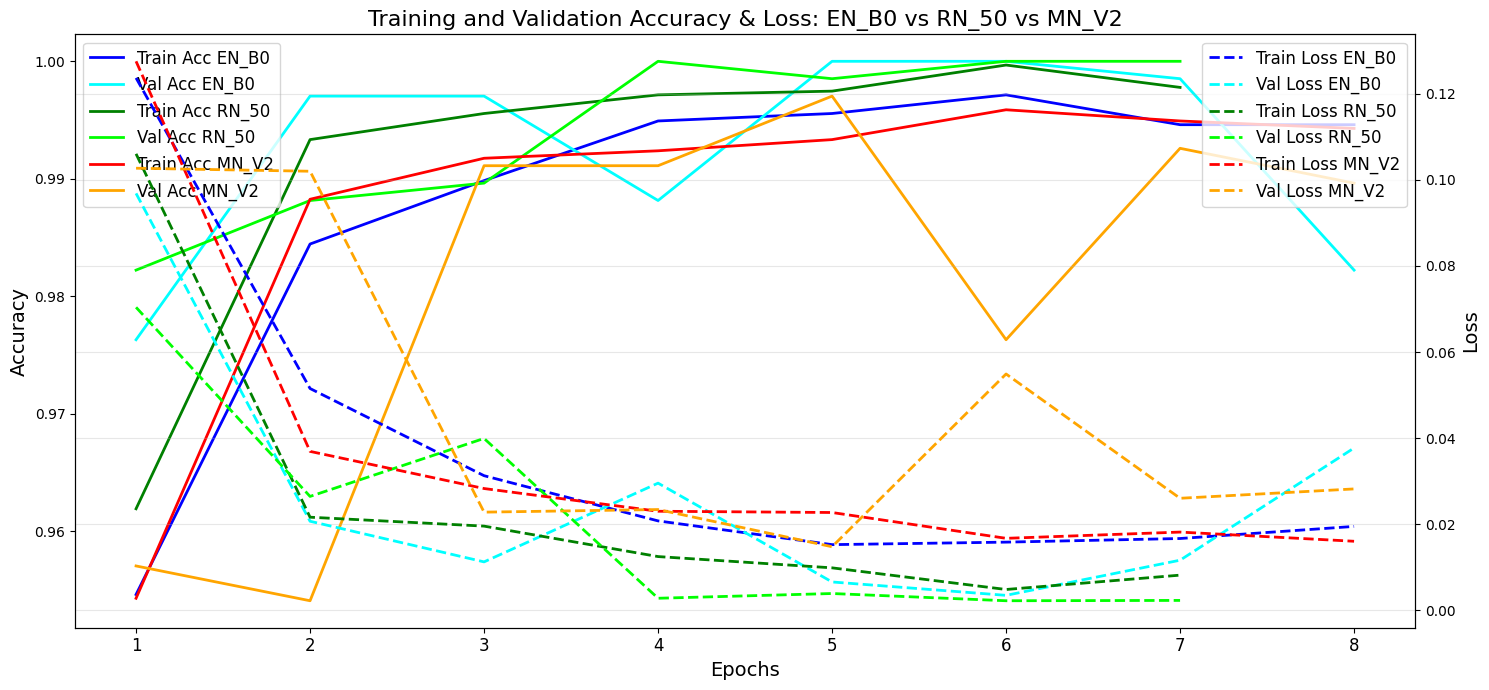

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(15, 7))

# Accuracy de EfficientNetB0
ax1.plot(np.arange(1, len(H_EN.history['accuracy']) + 1),
         H_EN.history['accuracy'], label='Train Acc EN_B0', color='blue',
         linewidth=2)
ax1.plot(np.arange(1, len(H_EN.history['val_accuracy']) + 1),
         H_EN.history['val_accuracy'], label='Val Acc EN_B0', color='cyan',
         linewidth=2)

# Accuracy de ResNet50
ax1.plot(np.arange(1, len(H_RN.history['accuracy']) + 1),
         H_RN.history['accuracy'], label='Train Acc RN_50', color='green',
         linewidth=2)
ax1.plot(np.arange(1, len(H_RN.history['val_accuracy']) + 1),
         H_RN.history['val_accuracy'], label='Val Acc RN_50', color='lime',
         linewidth=2)

# Accuracy de MobileNetV2
ax1.plot(np.arange(1, len(H_MN.history['accuracy']) + 1),
         H_MN.history['accuracy'], label='Train Acc MN_V2', color='red',
         linewidth=2)
ax1.plot(np.arange(1, len(H_MN.history['val_accuracy']) + 1),
         H_MN.history['val_accuracy'], label='Val Acc MN_V2', color='orange',
         linewidth=2)

ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xticks(np.arange(1, len(H_MN.history['accuracy']) + 1, 1))
ax1.legend(loc='upper left', fontsize=12)

ax2 = ax1.twinx()

# Pérdidas de EfficientNetB0
ax2.plot(np.arange(1, len(H_EN.history['loss']) + 1),
         H_EN.history['loss'], label='Train Loss EN_B0', color='blue',
         linewidth=2, linestyle='--')
ax2.plot(np.arange(1, len(H_EN.history['val_loss']) + 1),
         H_EN.history['val_loss'], label='Val Loss EN_B0', color='cyan',
         linewidth=2, linestyle='--')

# Pérdidas de ResNet50
ax2.plot(np.arange(1, len(H_RN.history['loss']) + 1),
         H_RN.history['loss'], label='Train Loss RN_50', color='green',
         linewidth=2, linestyle='--')
ax2.plot(np.arange(1, len(H_RN.history['val_loss']) + 1),
         H_RN.history['val_loss'], label='Val Loss RN_50', color='lime',
         linewidth=2, linestyle='--')

# Pérdidas de MobileNetV2
ax2.plot(np.arange(1, len(H_MN.history['loss']) + 1),
         H_MN.history['loss'], label='Train Loss MN_V2', color='red',
         linewidth=2, linestyle='--')
ax2.plot(np.arange(1, len(H_MN.history['val_loss']) + 1),
         H_MN.history['val_loss'], label='Val Loss MN_V2', color='orange',
         linewidth=2, linestyle='--')

ax2.set_ylabel('Loss', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)

# Mostrar gráfica y guardarla
plt.title('Training and Validation Accuracy & Loss: EN_B0 vs RN_50 vs MN_V2', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "learning_curves_lab_final_ex2.jpg"))
plt.show()

### <font color="orange"><font size="4"> ***4.1.2.- Precision, recall, f1-score, accuracy***

In [ ]:
#Librerías
from sklearn.metrics import (classification_report, precision_score,
    recall_score, f1_score, accuracy_score)

# Función para evaluar el modelo en imágenes de test
def evaluate_model(model, generator, set_name="Validation"):

    # Predicciones
    preds = model.predict(generator, verbose=1)
    y_true = generator.classes
    y_pred = np.argmax(preds, axis=1)

    class_labels = list(generator.class_indices.keys())
    print(f"\nResultados para {set_name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    # Obtener accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy total: {acc:.4f}")

    return preds, y_true, y_pred

---
<p align="center">
<font color="orange"><b>Modelo 1: EfficientNetB0

---



In [ ]:
# Evaluación en test
preds_test_EN, y_true_test_EN, y_pred_test_EN = evaluate_model(model_EN, test_generator_EN, "Test")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step

Resultados para Test:
                precision    recall  f1-score   support

       healthy     0.9956    1.0000    0.9978       225
  mosaic_virus     1.0000    0.9956    0.9978       225
powdery_mildew     1.0000    1.0000    1.0000       225

      accuracy                         0.9985       675
     macro avg     0.9985    0.9985    0.9985       675
  weighted avg     0.9985    0.9985    0.9985       675


Accuracy total: 0.9985


---
<p align="center">
<font color="orange"><b>Modelo 2: ResNet50

---

In [ ]:
# Evaluación en test
preds_test_RN, y_true_test_RN, y_pred_test_RN = evaluate_model(model_RN, test_generator_RN, "Test")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step

Resultados para Test:
                precision    recall  f1-score   support

       healthy     1.0000    1.0000    1.0000       225
  mosaic_virus     1.0000    1.0000    1.0000       225
powdery_mildew     1.0000    1.0000    1.0000       225

      accuracy                         1.0000       675
     macro avg     1.0000    1.0000    1.0000       675
  weighted avg     1.0000    1.0000    1.0000       675


Accuracy total: 1.0000


---
<p align="center">
<font color="orange"><b>Modelo 3: MobileNetV2

---

In [ ]:
# Evaluación en test
preds_test_MN, y_true_test_MN, y_pred_test_MN = evaluate_model(model_MN, test_generator_MN, "Test")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step

Resultados para Test:
                precision    recall  f1-score   support

       healthy     0.9825    1.0000    0.9912       225
  mosaic_virus     1.0000    0.9822    0.9910       225
powdery_mildew     1.0000    1.0000    1.0000       225

      accuracy                         0.9941       675
     macro avg     0.9942    0.9941    0.9941       675
  weighted avg     0.9942    0.9941    0.9941       675


Accuracy total: 0.9941


### <font color="orange"><font size="4"> ***4.1.3.- Matriz de confusión***

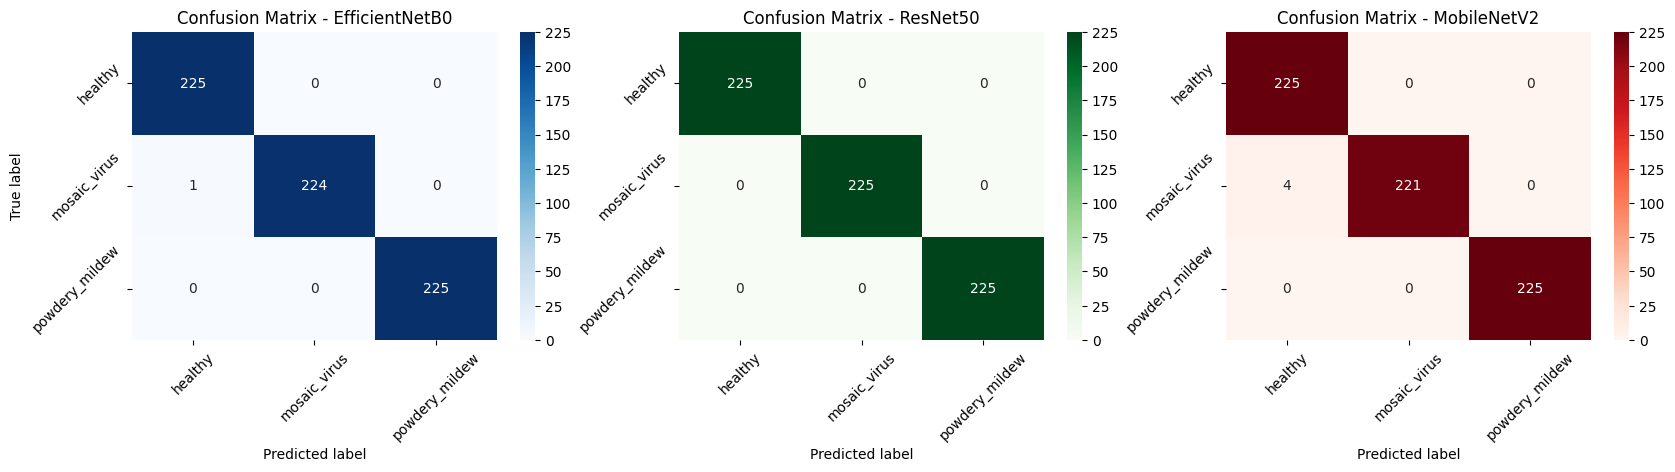

In [ ]:
#Librerías
from sklearn.metrics import (confusion_matrix)
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Generar matrices de confusión
cm_EN = confusion_matrix(y_true_test_EN, y_pred_test_EN)
cm_RN = confusion_matrix(y_true_test_RN, y_pred_test_RN)
cm_MN = confusion_matrix(y_true_test_MN, y_pred_test_MN)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Matriz de confusión EfficientNetB0
ax1 = sns.heatmap(cm_EN, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
colorbar1 = ax1.collections[0].colorbar
colorbar1.locator = MaxNLocator(integer=True)
colorbar1.update_ticks()
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_title("Confusion Matrix - EfficientNetB0")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=45)

# Matriz de confusión ResNet50
ax2 = sns.heatmap(cm_RN, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
colorbar2 = ax2.collections[0].colorbar
colorbar2.locator = MaxNLocator(integer=True)
colorbar2.update_ticks()
axes[1].set_xlabel("Predicted label")
axes[1].set_title("Confusion Matrix - ResNet50")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=45)

# Matriz de confusión MobileNetV2
ax3 = sns.heatmap(cm_MN, annot=True, fmt='d', cmap='Reds',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[2])
colorbar3 = ax3.collections[0].colorbar
colorbar3.locator = MaxNLocator(integer=True)
colorbar3.update_ticks()
axes[2].set_xlabel("Predicted label")
axes[2].set_title("Confusion Matrix - MobileNetV2")
axes[2].tick_params(axis="x", rotation=45)
axes[2].tick_params(axis="y", rotation=45)

# Guardar imágen de las matrices de confusión
plt.savefig(os.path.join(RESULTS_PATH, "confusion_matrices_lab_final_ex2.jpg"))

## <font color="orange"><font size="5"> **4.2.- Con imágenes de campo**

### <font color="orange"><font size="4"> ***4.2.1.- Obtener predicciones***

---
<p align="center">
<font color="orange"><b>Modelo 1: EfficientNetB0

---

In [ ]:
# Cargar modelo .h5 (EJECUTAR SOLO SI NO SE EJECUTA LA CELDA SIGUIENTE)
#from tensorflow.keras.models import load_model

#MODEL_FILE = ""  #Nombre del modelo .h5
#model_path = os.path.join(RESULTS_PATH, MODEL_NAME, MODEL_FILE)
#assert os.path.exists(model_path), f"No se encontró el modelo en {model_path}"
#MODEL_NAME = "EfficientNetB0"

#print(f"Cargando modelo desde: {model_path}")
#model = load_model(model_path)
#print("Modelo cargado correctamente.")

In [ ]:
# Seguir con el modelo ejecutado en memoria (EJECUTAR SOLO SI NO SE EJECUTA LA CELDA ANTERIOR)
model = model_EN
MODEL_NAME = "EfficientNetB0"

In [ ]:
# Predicciones con imágenes de campo de tomate
preds_EN_tomato = model.predict(test_generator_EN_field_tomato, verbose=1)
y_true_EN_tomato = test_generator_EN_field_tomato.classes
y_pred_EN_tomato = np.argmax(preds_EN_tomato, axis=1)
class_labels_EN_tomato = list(test_generator_EN_field_tomato.class_indices.keys())

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


In [ ]:
# Predicciones con imágenes de campo del resto de plantas
preds_EN_species = model.predict(test_generator_EN_field_species, verbose=1)
y_true_EN_species = test_generator_EN_field_species.classes
y_pred_EN_species = np.argmax(preds_EN_species, axis=1)
class_labels_EN_species = list(test_generator_EN_field_species.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 629ms/step


---
<p align="center">
<font color="orange"><b>Modelo 2: ResNet50

---

In [ ]:
# Cargar modelo .h5 (EJECUTAR SOLO SI NO SE EJECUTA LA CELDA SIGUIENTE)

#MODEL_FILE = ""  #Nombre del modelo .h5
#model_path = os.path.join(RESULTS_PATH, MODEL_NAME, MODEL_FILE)
#assert os.path.exists(model_path), f"No se encontró el modelo en {model_path}"
#MODEL_NAME = "ResNet50"

#print(f"Cargando modelo desde: {model_path}")
#model = load_model(model_path)
#print("Modelo cargado correctamente.")

In [ ]:
# Seguir con el modelo ejecutado en memoria (EJECUTAR SOLO SI NO SE EJECUTA LA CELDA ANTERIOR)
model = model_RN
MODEL_NAME = "ResNet50"

In [ ]:
# Predicciones con imágenes de campo de tomate
preds_RN_tomato = model.predict(test_generator_RN_field_tomato, verbose=1)
y_true_RN_tomato = test_generator_RN_field_tomato.classes
y_pred_RN_tomato = np.argmax(preds_RN_tomato, axis=1)
class_labels_RN_tomato = list(test_generator_RN_field_tomato.class_indices.keys())

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step


In [ ]:
# Predicciones con imágenes de campo del resto de plantas
preds_RN_species = model.predict(test_generator_RN_field_species, verbose=1)
y_true_RN_species = test_generator_RN_field_species.classes
y_pred_RN_species = np.argmax(preds_RN_species, axis=1)
class_labels_RN_species = list(test_generator_RN_field_species.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step


---
<p align="center">
<font color="orange"><b>Modelo 3: MobileNetV2

---

In [ ]:
# Cargar modelo .h5 (EJECUTAR SOLO SI NO SE EJECUTA LA CELDA SIGUIENTE)

#MODEL_FILE = ""  #Nombre del modelo .h5
#model_path = os.path.join(RESULTS_PATH, MODEL_NAME, MODEL_FILE)
#assert os.path.exists(model_path), f"No se encontró el modelo en {model_path}"
#MODEL_NAME = "MobileNetV2"

#print(f"Cargando modelo desde: {model_path}")
#model = load_model(model_path)
#print("Modelo cargado correctamente.")

In [ ]:
# Seguir con el modelo ejecutado en memoria (EJECUTAR SOLO SI NO SE EJECUTA LA CELDA ANTERIOR)
model = model_MN
MODEL_NAME = "MobileNetV2"

In [ ]:
# Predicciones con imágenes de campo de tomate
preds_MN_tomato = model.predict(test_generator_MN_field_tomato, verbose=1)
y_true_MN_tomato = test_generator_MN_field_tomato.classes
y_pred_MN_tomato = np.argmax(preds_MN_tomato, axis=1)
class_labels_MN_tomato = list(test_generator_MN_field_tomato.class_indices.keys())

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


In [ ]:
# Predicciones con imágenes de campo del resto de plantas
preds_MN_species = model.predict(test_generator_MN_field_species, verbose=1)
y_true_MN_species = test_generator_MN_field_species.classes
y_pred_MN_species = np.argmax(preds_MN_species, axis=1)
class_labels_MN_species = list(test_generator_MN_field_species.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step


### <font color="orange"><font size="4"> ***4.2.2.- Precision, recall, f1-score, accuracy***

---
<p align="center">
<font color="orange"><b>Modelo 1: EfficientNetB0

---

In [ ]:
# Evaluación en test de imágenes de campo de tomate

print("\nResultados para imágenes de campo de tomate - EfficientNetB0:")
print(classification_report(y_true_EN_tomato, y_pred_EN_tomato, target_names=class_labels_EN_tomato, digits=4))

acc_EN_tomato = accuracy_score(y_true_EN_tomato, y_pred_EN_tomato)
print(f"Accuracy total: {acc_EN_tomato:.4f}")


Resultados para imágenes de campo de tomate - EfficientNetB0:
                precision    recall  f1-score   support

       healthy     0.4000    0.2200    0.2839       100
  mosaic_virus     0.3438    0.5500    0.4231       100
powdery_mildew     0.6706    0.5700    0.6162       100

      accuracy                         0.4467       300
     macro avg     0.4714    0.4467    0.4411       300
  weighted avg     0.4714    0.4467    0.4411       300

Accuracy total: 0.4467


In [ ]:
# Evaluación en test de imágenes de campo del resto de plantas

print("\nResultados para imágenes de campo del resto de plantas - EfficientNetB0:")
print(classification_report(y_true_EN_species, y_pred_EN_species, target_names=class_labels_EN_species, digits=4))

acc_EN_species = accuracy_score(y_true_EN_species, y_pred_EN_species)
print(f"Accuracy total: {acc_EN_species:.4f}")


Resultados para imágenes de campo del resto de plantas - EfficientNetB0:
                precision    recall  f1-score   support

       healthy     0.5761    0.4450    0.5021       400
  mosaic_virus     0.5645    0.1750    0.2672       400
powdery_mildew     0.3911    0.7500    0.5141       400

      accuracy                         0.4567      1200
     macro avg     0.5106    0.4567    0.4278      1200
  weighted avg     0.5106    0.4567    0.4278      1200

Accuracy total: 0.4567


---
<p align="center">
<font color="orange"><b>Modelo 2: ResNet50

---

In [ ]:
# Evaluación en test de imágenes de campo de tomate

print("\nResultados para imágenes de campo de tomate - ResNet50:")
print(classification_report(y_true_RN_tomato, y_pred_RN_tomato, target_names=class_labels_RN_tomato, digits=4))

acc_RN_tomato = accuracy_score(y_true_RN_tomato, y_pred_RN_tomato)
print(f"Accuracy total: {acc_RN_tomato:.4f}")


Resultados para imágenes de campo de tomate - ResNet50:
                precision    recall  f1-score   support

       healthy     1.0000    0.0100    0.0198       100
  mosaic_virus     0.3750    0.8400    0.5185       100
powdery_mildew     0.6667    0.5000    0.5714       100

      accuracy                         0.4500       300
     macro avg     0.6806    0.4500    0.3699       300
  weighted avg     0.6806    0.4500    0.3699       300

Accuracy total: 0.4500


In [ ]:
# Evaluación en test de imágenes de campo del resto de plantas

print("\nResultados para imágenes de campo del resto de plantas - ResNet50:")
print(classification_report(y_true_RN_species, y_pred_RN_species, target_names=class_labels_RN_species, digits=4))

acc_RN_species = accuracy_score(y_true_RN_species, y_pred_RN_species)
print(f"Accuracy total: {acc_RN_species:.4f}")


Resultados para imágenes de campo del resto de plantas - ResNet50:
                precision    recall  f1-score   support

       healthy     0.6818    0.0750    0.1351       400
  mosaic_virus     0.4693    0.8600    0.6072       400
powdery_mildew     0.5201    0.5500    0.5346       400

      accuracy                         0.4950      1200
     macro avg     0.5571    0.4950    0.4257      1200
  weighted avg     0.5571    0.4950    0.4257      1200

Accuracy total: 0.4950


---
<p align="center">
<font color="orange"><b>Modelo 3: MobileNetV2

---

In [ ]:
# Evaluación en test de imágenes de campo de tomate

print("\nResultados para imágenes de campo de tomate - MobileNetV2:")
print(classification_report(y_true_MN_tomato, y_pred_MN_tomato, target_names=class_labels_MN_tomato, digits=4))

acc_MN_tomato = accuracy_score(y_true_MN_tomato, y_pred_MN_tomato)
print(f"Accuracy total: {acc_MN_tomato:.4f}")


Resultados para imágenes de campo de tomate - MobileNetV2:
                precision    recall  f1-score   support

       healthy     0.6522    0.1500    0.2439       100
  mosaic_virus     0.2745    0.1400    0.1854       100
powdery_mildew     0.3850    0.8700    0.5337       100

      accuracy                         0.3867       300
     macro avg     0.4372    0.3867    0.3210       300
  weighted avg     0.4372    0.3867    0.3210       300

Accuracy total: 0.3867


In [ ]:
# Evaluación en test de imágenes de campo del resto de plantas

print("\nResultados para imágenes de campo del resto de plantas - MobileNetV2:")
print(classification_report(y_true_MN_species, y_pred_MN_species, target_names=class_labels_MN_species, digits=4))

acc_MN_species = accuracy_score(y_true_MN_species, y_pred_MN_species)
print(f"Accuracy total: {acc_MN_species:.4f}")


Resultados para imágenes de campo del resto de plantas - MobileNetV2:
                precision    recall  f1-score   support

       healthy     0.4847    0.2375    0.3188       400
  mosaic_virus     0.7260    0.1325    0.2241       400
powdery_mildew     0.3856    0.8975    0.5394       400

      accuracy                         0.4225      1200
     macro avg     0.5321    0.4225    0.3608      1200
  weighted avg     0.5321    0.4225    0.3608      1200

Accuracy total: 0.4225


### <font color="orange"><font size="4"> ***4.2.3.- Matriz de confusión***

---
<p align="center">
<font color="orange"><b>Modelo 1: EfficientNetB0

---

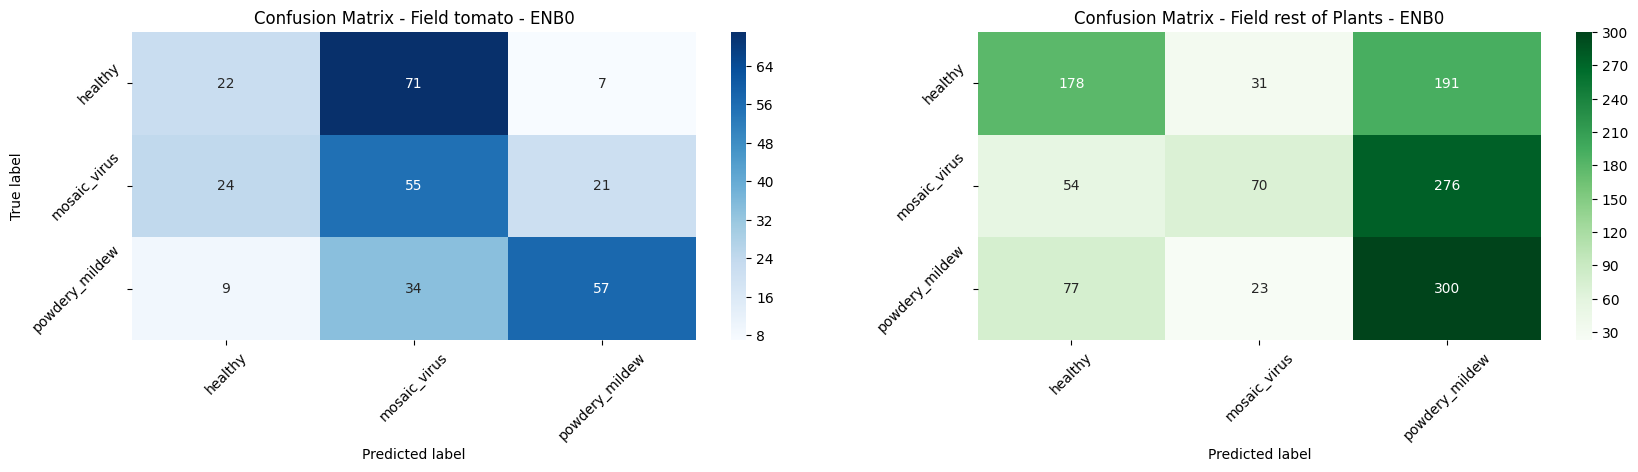

In [ ]:
#Librerías
from sklearn.metrics import (confusion_matrix)
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Generar matrices de confusión
cm_EN_tomato = confusion_matrix(y_true_EN_tomato, y_pred_EN_tomato)
cm_EN_species = confusion_matrix(y_true_EN_species, y_pred_EN_species)

# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Matriz de confusión tomate
ax1 = sns.heatmap(cm_EN_tomato, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
colorbar1 = ax1.collections[0].colorbar
colorbar1.locator = MaxNLocator(integer=True)
colorbar1.update_ticks()
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_title("Confusion Matrix - Field tomato - ENB0")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=45)

# Matriz de confusión resto de plantas
ax2 = sns.heatmap(cm_EN_species, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
colorbar2 = ax2.collections[0].colorbar
colorbar2.locator = MaxNLocator(integer=True)
colorbar2.update_ticks()
axes[1].set_xlabel("Predicted label")
axes[1].set_title("Confusion Matrix - Field rest of Plants - ENB0")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=45)

# Guardar matriz de confusión
model_name="EfficientNetB0"
plt.savefig(os.path.join(RESULTS_PATH, f"cm_field_final_ex2_{model_name}.jpg"))

---
<p align="center">
<font color="orange"><b>Modelo 2: ResNet50

---

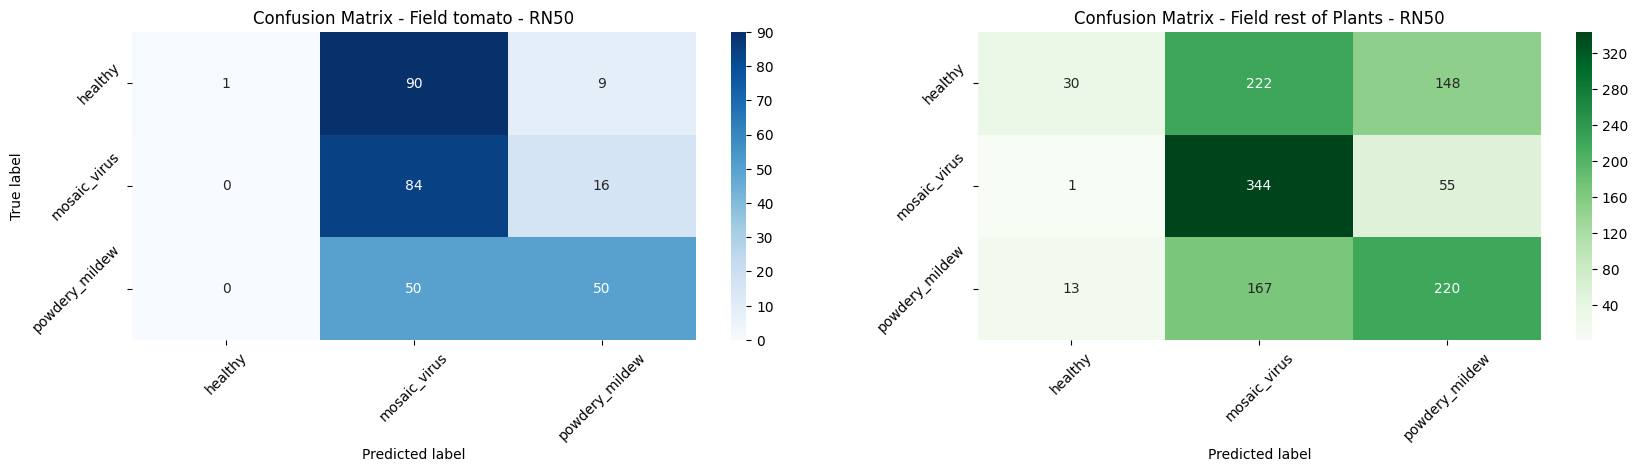

In [ ]:
# Generar matrices de confusión
cm_RN_tomato = confusion_matrix(y_true_RN_tomato, y_pred_RN_tomato)
cm_RN_species = confusion_matrix(y_true_RN_species, y_pred_RN_species)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Matriz de confusión tomate
ax1 = sns.heatmap(cm_RN_tomato, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
colorbar1 = ax1.collections[0].colorbar
colorbar1.locator = MaxNLocator(integer=True)
colorbar1.update_ticks()
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_title("Confusion Matrix - Field tomato - RN50")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=45)

# Matriz de confusión resto de plantas
ax2 = sns.heatmap(cm_RN_species, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
colorbar2 = ax2.collections[0].colorbar
colorbar2.locator = MaxNLocator(integer=True)
colorbar2.update_ticks()
axes[1].set_xlabel("Predicted label")
axes[1].set_title("Confusion Matrix - Field rest of Plants - RN50")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=45)

# Guardar matriz de confusión
model_name="ResNet50"
plt.savefig(os.path.join(RESULTS_PATH, f"cm_field_final_ex2_{model_name}.jpg"))

---
<p align="center">
<font color="orange"><b>Modelo 3: MobileNetV2

---

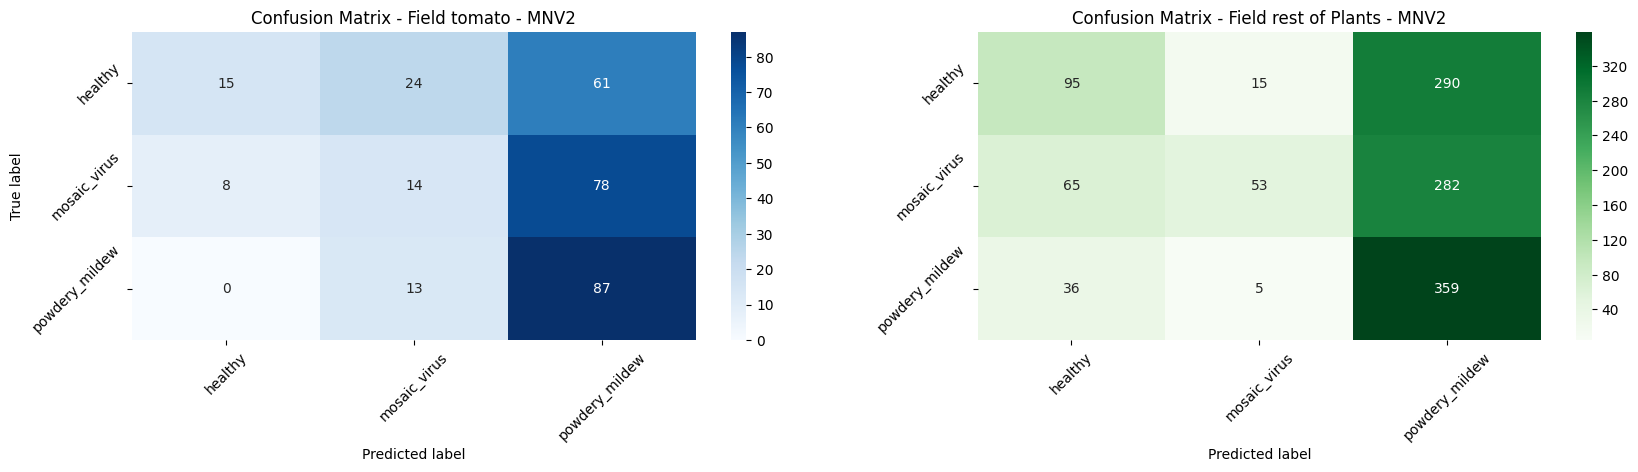

In [ ]:
# Generar matrices de confusión
cm_MN_tomato = confusion_matrix(y_true_MN_tomato, y_pred_MN_tomato)
cm_MN_species = confusion_matrix(y_true_MN_species, y_pred_MN_species)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Matriz de confusión tomate
ax1 = sns.heatmap(cm_MN_tomato, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
colorbar1 = ax1.collections[0].colorbar
colorbar1.locator = MaxNLocator(integer=True)
colorbar1.update_ticks()
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_title("Confusion Matrix - Field tomato - MNV2")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=45)

# Matriz de confusión resto de plantas
ax2 = sns.heatmap(cm_MN_species, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
colorbar2 = ax2.collections[0].colorbar
colorbar2.locator = MaxNLocator(integer=True)
colorbar2.update_ticks()
axes[1].set_xlabel("Predicted label")
axes[1].set_title("Confusion Matrix - Field rest of Plants - MNV2")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=45)

# Guardar matriz de confusión
model_name="MobileNetV2"
plt.savefig(os.path.join(RESULTS_PATH, f"cm_field_final_ex2_{model_name}.jpg"))

### <font color="orange"><font size="4"> ***4.2.4.- Observar imágenes mal clasificadas***

---
<p align="center">
<font color="orange"><b>Función para mostrar tabla con lista de imágenes y su clasificación

---

In [ ]:
# Librerías
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Función para mostrar nombre imagen y su clasificación
def build_results_table(generator, preds, y_true, y_pred, class_labels, model_name, set_name, RESULTS_PATH=RESULTS_PATH):
    """Genera tabla de resultados detallada."""
    probs = np.max(preds, axis=1)  # probabilidad máxima
    filenames = [os.path.basename(f) for f in generator.filenames]

    results_df = pd.DataFrame({
        'Imagen': filenames,
        'Clase correcta': [class_labels[i] for i in y_true],
        'Clase predicha': [class_labels[i] for i in y_pred],
        'Probabilidad': probs,
        'Acierto': ['si' if y_true[i] == y_pred[i] else 'no' for i in range(len(y_true))]})

    print(f"\nResultados detallados - {model_name} ({set_name}):")
    display(results_df.head(15))

    # Guardar CSV
    out_csv = os.path.join(RESULTS_PATH, f"predicciones_{model_name}_final_ex2_{set_name}.csv")
    results_df.to_csv(out_csv, index=False)
    print(f"\nTabla guardada en: {out_csv}")

    # Mostrar resumen por clase
    resumen = results_df.groupby(['Clase correcta', 'Acierto']).size().unstack(fill_value=0)
    print("\nResumen de aciertos por clase:")
    display(resumen)

    return results_df

---
<p align="center">
<font color="orange"><b>Función para ver las imágenes mal clasificadas

---

In [ ]:
# Función para mostrar imágenes mal clasificadas (una por clase y planta)
def mostrar_mal_clasificadas(generator, preds, y_true, y_pred, class_labels, model_name, set_name, n_mostrar=15, RESULTS_PATH=RESULTS_PATH):
    """Muestra imágenes mal clasificadas, seleccionando una por clase si es posible."""
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import os

    np.random.seed(42)  # semilla para asegurar reproducibilidad

    filenames = np.array(generator.filepaths)
    misclassified_idx = np.where(y_true != y_pred)[0]

    if len(misclassified_idx) == 0:
        print(f"\nNo hay imágenes mal clasificadas en {model_name} ({set_name})")
        return

    seleccion = []
    # Seleccionar una imagen mal clasificada por clase (si existe)
    for clase in np.unique(y_true):
        idx_clase = np.where((y_true == clase) & (y_true != y_pred))[0]
        if len(idx_clase) > 0:
            seleccion.append(idx_clase[0])  # primera mal clasificada de esa clase

    # Si hay menos de las solicitadas, rellena con otras aleatorias
    restantes = list(set(misclassified_idx) - set(seleccion))
    if len(seleccion) < n_mostrar and len(restantes) > 0:
        adicionales = np.random.choice(restantes, min(n_mostrar - len(seleccion), len(restantes)), replace=False)
        seleccion.extend(adicionales)

    n_mostrar = len(seleccion)
    print(f"\nMostrando {n_mostrar} imágenes mal clasificadas - {model_name} ({set_name})")

    # Visualización
    plt.figure(figsize=(15, 3 * ((n_mostrar // 5) + 1)))
    for i, idx in enumerate(seleccion, 1):
        img = mpimg.imread(filenames[idx])
        prob = np.max(preds[idx])
        plt.subplot((n_mostrar // 5) + 1, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Real: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}\nProb: {prob:.2f}",
            fontsize=9, color="red")
    plt.tight_layout()

    # Guardar imagen
    out_path = os.path.join(RESULTS_PATH, f"misclassified_{model_name}_{set_name}_final_ex2.jpg")
    plt.savefig(out_path, dpi=150)
    plt.show()

    print(f"Imagen guardada en: {out_path}")

---
<p align="center">
<font color="orange"><b>Modelo 1: EfficientNetB0

---

In [ ]:
# Mostrar resultado de las primeras 15 imágenes
df_EN_tomato = build_results_table(test_generator_EN_field_tomato, preds_EN_tomato, y_true_EN_tomato, y_pred_EN_tomato, class_labels_EN_tomato, "EfficientNetB0", "CampoTomate")
df_EN_species = build_results_table(test_generator_EN_field_species, preds_EN_species, y_true_EN_species, y_pred_EN_species, class_labels_EN_species, "EfficientNetB0", "CampoEspecies")


Resultados detallados - EfficientNetB0 (CampoTomate):


Imagen Clase correcta  \
0   seg_tomato_field_healthy_dataset04_image001.jpg        healthy   
1   seg_tomato_field_healthy_dataset04_image002.jpg        healthy   
2   seg_tomato_field_healthy_dataset04_image003.jpg        healthy   
3   seg_tomato_field_healthy_dataset04_image004.jpg        healthy   
4   seg_tomato_field_healthy_dataset04_image005.jpg        healthy   
5   seg_tomato_field_healthy_dataset04_image006.jpg        healthy   
6   seg_tomato_field_healthy_dataset04_image007.jpg        healthy   
7   seg_tomato_field_healthy_dataset04_image008.jpg        healthy   
8   seg_tomato_field_healthy_dataset04_image009.jpg        healthy   
9   seg_tomato_field_healthy_dataset04_image010.jpg        healthy   
10  seg_tomato_field_healthy_dataset04_image011.jpg        healthy   
11  seg_tomato_field_healthy_dataset04_image012.jpg        healthy   
12  seg_tomato_field_healthy_dataset04_image013.jpg        healthy   
13  seg_tomato_field_healthy_dataset04_image014.jpg        healthy   
14  seg_tomato_field_healthy_dataset04_image015.jpg        healthy   

   Clase predicha  Probabilidad Acierto  
0    mosaic_virus      0.738269      no  
1    mosaic_virus      0.651063      no  
2    mosaic_virus      0.965898      no  
3    mosaic_virus      0.986978      no  
4    mosaic_virus      0.956517      no  
5    mosaic_virus      0.913580      no  
6    mosaic_virus      0.971532      no  
7    mosaic_virus      0.851154      no  
8    mosaic_virus      0.970791      no  
9    mosaic_virus      0.984290      no  
10   mosaic_virus      0.986176      no  
11   mosaic_virus      0.889554      no  
12   mosaic_virus      0.427666      no  
13   mosaic_virus      0.858368      no  
14   mosaic_virus      0.980436      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/predicciones_EfficientNetB0_final_ex2_CampoTomate.csv

Resumen de aciertos por clase:


Acierto         no  si
Clase correcta        
healthy         78  22
mosaic_virus    45  55
powdery_mildew  43  57


Resultados detallados - EfficientNetB0 (CampoEspecies):


Imagen Clase correcta  \
0   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
1   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
2   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
3   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
4   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
5   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
6   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
7   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
8   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
9   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
10  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
11  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
12  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
13  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
14  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   

    Clase predicha  Probabilidad Acierto  
0   powdery_mildew      0.842319      no  
1   powdery_mildew      0.955285      no  
2   powdery_mildew      0.785674      no  
3   powdery_mildew      0.868043      no  
4          healthy      0.552159      si  
5     mosaic_virus      0.611035      no  
6          healthy      0.889556      si  
7          healthy      0.991266      si  
8          healthy      0.781982      si  
9          healthy      0.888292      si  
10  powdery_mildew      0.570259      no  
11  powdery_mildew      0.829183      no  
12         healthy      0.937229      si  
13         healthy      0.978386      si  
14  powdery_mildew      0.731685      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/predicciones_EfficientNetB0_final_ex2_CampoEspecies.csv

Resumen de aciertos por clase:


Acierto          no   si
Clase correcta          
healthy         222  178
mosaic_virus    330   70
powdery_mildew  100  300

In [ ]:
# Mostrar imágenes mal clasificadas
mostrar_mal_clasificadas(test_generator_EN_field_tomato, preds_EN_tomato, y_true_EN_tomato, y_pred_EN_tomato, class_labels_EN_tomato, "EfficientNetB0", "CampoTomate", n_mostrar=15)
mostrar_mal_clasificadas(test_generator_EN_field_species, preds_EN_species, y_true_EN_species, y_pred_EN_species, class_labels_EN_species, "EfficientNetB0", "CampoEspecies", n_mostrar=15)

Output hidden; open in https://colab.research.google.com to view.

---
<p align="center">
<font color="orange"><b>Modelo 2: ResNet50

---

In [ ]:
# Mostrar resultado de las primeras 15 imágenes
df_RN_tomato = build_results_table(test_generator_RN_field_tomato, preds_RN_tomato, y_true_RN_tomato, y_pred_RN_tomato, class_labels_RN_tomato, "ResNet50", "CampoTomate")
df_RN_species = build_results_table(test_generator_RN_field_species, preds_RN_species, y_true_RN_species, y_pred_RN_species, class_labels_RN_species, "ResNet50", "CampoEspecies")


Resultados detallados - ResNet50 (CampoTomate):


Imagen Clase correcta  \
0   seg_tomato_field_healthy_dataset04_image001.jpg        healthy   
1   seg_tomato_field_healthy_dataset04_image002.jpg        healthy   
2   seg_tomato_field_healthy_dataset04_image003.jpg        healthy   
3   seg_tomato_field_healthy_dataset04_image004.jpg        healthy   
4   seg_tomato_field_healthy_dataset04_image005.jpg        healthy   
5   seg_tomato_field_healthy_dataset04_image006.jpg        healthy   
6   seg_tomato_field_healthy_dataset04_image007.jpg        healthy   
7   seg_tomato_field_healthy_dataset04_image008.jpg        healthy   
8   seg_tomato_field_healthy_dataset04_image009.jpg        healthy   
9   seg_tomato_field_healthy_dataset04_image010.jpg        healthy   
10  seg_tomato_field_healthy_dataset04_image011.jpg        healthy   
11  seg_tomato_field_healthy_dataset04_image012.jpg        healthy   
12  seg_tomato_field_healthy_dataset04_image013.jpg        healthy   
13  seg_tomato_field_healthy_dataset04_image014.jpg        healthy   
14  seg_tomato_field_healthy_dataset04_image015.jpg        healthy   

    Clase predicha  Probabilidad Acierto  
0     mosaic_virus      0.999855      no  
1     mosaic_virus      0.929737      no  
2     mosaic_virus      0.996851      no  
3   powdery_mildew      0.703903      no  
4     mosaic_virus      0.980341      no  
5     mosaic_virus      0.961994      no  
6   powdery_mildew      0.518790      no  
7     mosaic_virus      0.998063      no  
8     mosaic_virus      0.950436      no  
9     mosaic_virus      0.997846      no  
10    mosaic_virus      0.998910      no  
11    mosaic_virus      0.959894      no  
12    mosaic_virus      0.992471      no  
13    mosaic_virus      0.999863      no  
14    mosaic_virus      0.999767      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/predicciones_ResNet50_final_ex2_CampoTomate.csv

Resumen de aciertos por clase:


Acierto         no  si
Clase correcta        
healthy         99   1
mosaic_virus    16  84
powdery_mildew  50  50


Resultados detallados - ResNet50 (CampoEspecies):


Imagen Clase correcta  \
0   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
1   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
2   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
3   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
4   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
5   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
6   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
7   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
8   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
9   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
10  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
11  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
12  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
13  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
14  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   

    Clase predicha  Probabilidad Acierto  
0     mosaic_virus      0.975711      no  
1   powdery_mildew      0.677090      no  
2     mosaic_virus      0.987427      no  
3     mosaic_virus      0.998604      no  
4     mosaic_virus      0.985302      no  
5     mosaic_virus      0.998090      no  
6     mosaic_virus      0.963828      no  
7     mosaic_virus      0.992499      no  
8     mosaic_virus      0.981555      no  
9   powdery_mildew      0.929045      no  
10    mosaic_virus      0.550212      no  
11    mosaic_virus      0.894795      no  
12    mosaic_virus      0.997380      no  
13  powdery_mildew      0.559757      no  
14    mosaic_virus      0.529659      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/predicciones_ResNet50_final_ex2_CampoEspecies.csv

Resumen de aciertos por clase:


Acierto          no   si
Clase correcta          
healthy         370   30
mosaic_virus     56  344
powdery_mildew  180  220

In [ ]:
# Mostrar imágenes mal clasificadas
mostrar_mal_clasificadas(test_generator_RN_field_tomato, preds_RN_tomato, y_true_RN_tomato, y_pred_RN_tomato, class_labels_RN_tomato, "ResNet50", "CampoTomate", n_mostrar=15)
mostrar_mal_clasificadas(test_generator_RN_field_species, preds_RN_species, y_true_RN_species, y_pred_RN_species, class_labels_RN_species, "ResNet50", "CampoEspecies", n_mostrar=15)

Output hidden; open in https://colab.research.google.com to view.

---
<p align="center">
<font color="orange"><b>Modelo 3: MobileNetV2

---

In [ ]:
# Mostrar resultado de las primeras 15 imágenes
df_MN_tomato = build_results_table(test_generator_MN_field_tomato, preds_MN_tomato, y_true_MN_tomato, y_pred_MN_tomato, class_labels_MN_tomato, "MobileNetV2", "CampoTomate")
df_MN_species = build_results_table(test_generator_MN_field_species, preds_MN_species, y_true_MN_species, y_pred_MN_species, class_labels_MN_species, "MobileNetV2", "CampoEspecies")


Resultados detallados - MobileNetV2 (CampoTomate):


Imagen Clase correcta  \
0   seg_tomato_field_healthy_dataset04_image001.jpg        healthy   
1   seg_tomato_field_healthy_dataset04_image002.jpg        healthy   
2   seg_tomato_field_healthy_dataset04_image003.jpg        healthy   
3   seg_tomato_field_healthy_dataset04_image004.jpg        healthy   
4   seg_tomato_field_healthy_dataset04_image005.jpg        healthy   
5   seg_tomato_field_healthy_dataset04_image006.jpg        healthy   
6   seg_tomato_field_healthy_dataset04_image007.jpg        healthy   
7   seg_tomato_field_healthy_dataset04_image008.jpg        healthy   
8   seg_tomato_field_healthy_dataset04_image009.jpg        healthy   
9   seg_tomato_field_healthy_dataset04_image010.jpg        healthy   
10  seg_tomato_field_healthy_dataset04_image011.jpg        healthy   
11  seg_tomato_field_healthy_dataset04_image012.jpg        healthy   
12  seg_tomato_field_healthy_dataset04_image013.jpg        healthy   
13  seg_tomato_field_healthy_dataset04_image014.jpg        healthy   
14  seg_tomato_field_healthy_dataset04_image015.jpg        healthy   

    Clase predicha  Probabilidad Acierto  
0     mosaic_virus      0.934831      no  
1   powdery_mildew      0.937771      no  
2     mosaic_virus      0.432712      no  
3   powdery_mildew      0.863045      no  
4   powdery_mildew      0.922631      no  
5   powdery_mildew      0.976913      no  
6   powdery_mildew      0.923783      no  
7   powdery_mildew      0.798274      no  
8     mosaic_virus      0.537660      no  
9   powdery_mildew      0.993655      no  
10    mosaic_virus      0.807500      no  
11  powdery_mildew      0.987251      no  
12  powdery_mildew      0.637345      no  
13  powdery_mildew      0.590428      no  
14  powdery_mildew      0.997460      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/predicciones_MobileNetV2_final_ex2_CampoTomate.csv

Resumen de aciertos por clase:


Acierto         no  si
Clase correcta        
healthy         85  15
mosaic_virus    86  14
powdery_mildew  13  87


Resultados detallados - MobileNetV2 (CampoEspecies):


Imagen Clase correcta  \
0   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
1   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
2   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
3   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
4   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
5   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
6   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
7   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
8   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
9   seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
10  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
11  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
12  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
13  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   
14  seg_bell_pepper_field_healthy_dataset05_image0...        healthy   

    Clase predicha  Probabilidad Acierto  
0   powdery_mildew      0.557697      no  
1   powdery_mildew      0.999855      no  
2   powdery_mildew      0.802330      no  
3          healthy      0.988305      si  
4          healthy      0.494582      si  
5   powdery_mildew      0.433231      no  
6   powdery_mildew      0.995656      no  
7   powdery_mildew      0.786884      no  
8          healthy      0.940417      si  
9   powdery_mildew      0.823697      no  
10  powdery_mildew      0.925956      no  
11  powdery_mildew      0.996330      no  
12         healthy      0.631067      si  
13  powdery_mildew      0.978730      no  
14  powdery_mildew      0.977804      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/predicciones_MobileNetV2_final_ex2_CampoEspecies.csv

Resumen de aciertos por clase:


Acierto          no   si
Clase correcta          
healthy         305   95
mosaic_virus    347   53
powdery_mildew   41  359

In [ ]:
# Mostrar imágenes mal clasificadas
mostrar_mal_clasificadas(test_generator_MN_field_tomato, preds_MN_tomato, y_true_MN_tomato, y_pred_MN_tomato, class_labels_MN_tomato, "MobileNetV2", "CampoTomate", n_mostrar=15)
mostrar_mal_clasificadas(test_generator_MN_field_species, preds_MN_species, y_true_MN_species, y_pred_MN_species, class_labels_MN_species, "MobileNetV2", "CampoEspecies", n_mostrar=15)

Output hidden; open in https://colab.research.google.com to view.

## <font color="orange"><font size="5"> **4.3.- Comparación de resultados**

### <font color="orange"><font size="4"> ***4.3.1.- Tabla comparativa final de métricas***

In [ ]:
# Librerías
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Función para resumir métricas
def resumen_metricas(y_true, y_pred, modelo, dominio):
    return {
        "Modelo": modelo,
        "Dominio": dominio,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro"),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro"),
        "F1-score (macro)": f1_score(y_true, y_pred, average="macro")}

In [ ]:
# Crear lista de resultados
metricas = [
    resumen_metricas(y_true_test_EN, y_pred_test_EN, "EfficientNetB0", "Laboratorio"),
    resumen_metricas(y_true_test_RN, y_pred_test_RN, "ResNet50", "Laboratorio"),
    resumen_metricas(y_true_test_MN, y_pred_test_MN, "MobileNetV2", "Laboratorio"),
    resumen_metricas(y_true_EN_tomato, y_pred_EN_tomato, "EfficientNetB0", "Campo Tomate"),
    resumen_metricas(y_true_RN_tomato, y_pred_RN_tomato, "ResNet50", "Campo Tomate"),
    resumen_metricas(y_true_MN_tomato, y_pred_MN_tomato, "MobileNetV2", "Campo Tomate"),
    resumen_metricas(y_true_EN_species, y_pred_EN_species, "EfficientNetB0", "Campo Especies"),
    resumen_metricas(y_true_RN_species, y_pred_RN_species, "ResNet50", "Campo Especies"),
    resumen_metricas(y_true_MN_species, y_pred_MN_species, "MobileNetV2", "Campo Especies")]

# Convertir a DataFrame
df_metricas = pd.DataFrame(metricas)

# Aplicar formato solo a columnas numéricas
numeric_cols = df_metricas.select_dtypes(include=['number']).columns
display(df_metricas.style.background_gradient(cmap="YlGn").format({col: "{:.4f}" for col in numeric_cols}))

# Guardar resultados en formato CSV
output_path = os.path.join(RESULTS_PATH, "metricas_comparativas_final_ex2.csv")
df_metricas.to_csv(output_path, index=False)
print(f"\nTabla guardada en: {output_path}")


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/metricas_comparativas_final_ex2.csv


### <font color="orange"><font size="4"> ***4.3.2.- Gráfico comparativo de métricas***

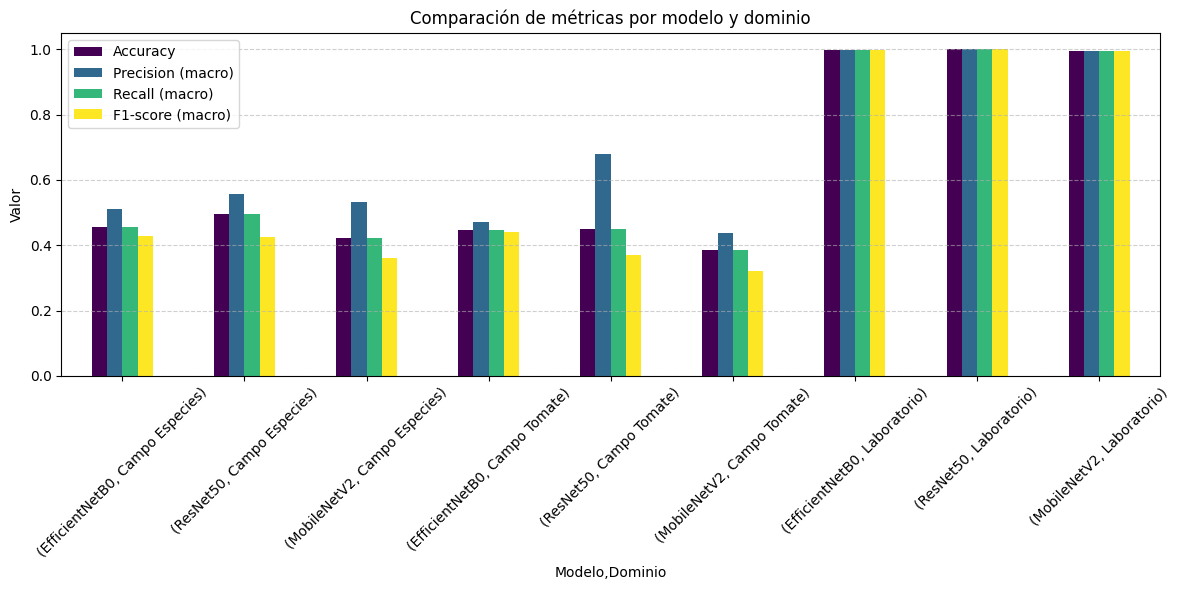

In [ ]:
# Ordenar métricas por dominio (lab vs field)
df_metricas = df_metricas.sort_values(["Dominio"]).reset_index(drop=True)

# Mostrar gráfico de barras y guardarlo
df_metricas.set_index(["Modelo", "Dominio"])[["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"]].plot(
    kind="bar", figsize=(12,6), rot=45, colormap="viridis")
plt.title("Comparación de métricas por modelo y dominio")
plt.ylabel("Valor")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(os.path.join(RESULTS_PATH, "comparacion_metricas_todos-los-modelos_barplot_final_ex2.jpg"))
plt.show()

### <font color="orange"><font size="4"> ***4.3.3.- Comparación Grad-CAM***

---
<p align="center">
<font color="orange"><b>Función Grad-CAM

---

In [ ]:
def gradcam_simple(model, img_path, base_model_name, last_conv_layer_name, preprocess_func,
                   planta=None, enfermedad=None, save=True, results_path=RESULTS_PATH,
                   class_labels=CLASSES, true_label=None):
    """Genera y guarda Grad-CAM mostrando clase real y predicha."""

    # Librerías
    import numpy as np, matplotlib.pyplot as plt, tensorflow as tf, cv2, os
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras import Model

    # Preprocesamiento
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)

    # Modelo y capa
    base_model = model.layers[0]
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=base_model.input,
                       outputs=[last_conv_layer.output, base_model.output])

    # Gradientes
    with tf.GradientTape() as tape:
        conv_output, base_output = grad_model(img_array)
        x = base_output
        for layer in model.layers[1:]:
            x = layer(x)
        preds = x
        pred_index = tf.argmax(preds[0])
        top_class = preds[:, pred_index]

    grads = tape.gradient(top_class, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Superposición
    img_orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (256, 256))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

    # Etiquetas
    pred_label = class_labels[int(pred_index)] if class_labels is not None else f"Clase {int(pred_index)}"
    true_label = true_label or enfermedad or "Desconocida"
    prob = float(tf.reduce_max(preds))

    # Visualización
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.axis('off')
    plt.title(f"Original\nReal: {true_label}")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.axis('off')
    plt.title(f"Grad-CAM\nPred: {pred_label} ({prob:.2f})")

    plt.tight_layout()
    plt.show()

    # Guardado
    if save:
        save_dir = os.path.join(results_path, base_model_name)
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        filename = f"{base_model_name}_{planta or 'NA'}_{true_label}_{base_name}_pred-{pred_label}_final_ex2.jpg"
        out_path = os.path.join(save_dir, filename)
        cv2.imwrite(out_path, cv2.cvtColor(superimposed, cv2.COLOR_RGB2BGR))
        print(f"Imagen Grad-CAM guardada en: {out_path}")

---
<p align="center">
<font color="orange"><b>Imágenes generadas con Grad-CAM

---

In [ ]:
# Ejemplo 1: evaluar grad-CAM sobre imagen de "healthy" según los 3 modelos

from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnetb0
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

# Resultados con modelo EfficientNetB0
gradcam_simple(model_EN, "/content/dataset/bell_pepper/field/healthy/seg_bell_pepper_field_healthy_dataset05_image001.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="bell_pepper", enfermedad="healthy")
gradcam_simple(model_EN, "/content/dataset/cucumber/field/healthy/seg_cucumber_field_healthy_dataset21_image030.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="cucumber", enfermedad="healthy")
gradcam_simple(model_EN, "/content/dataset/eggplant/field/healthy/seg_eggplant_field_healthy_dataset16_image037.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="eggplant", enfermedad="healthy")
gradcam_simple(model_EN, "/content/dataset/pumpkin/field/healthy/seg_pumpkin_field_healthy_dataset08_image050.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="pumpkin", enfermedad="healthy")
gradcam_simple(model_EN, "/content/dataset/tomato/field/healthy/seg_tomato_field_healthy_dataset04_image006.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="tomato", enfermedad="healthy")
gradcam_simple(model_EN, "/content/dataset/tomato/lab/healthy/seg_tomato_lab_healthy_dataset01_image0086.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="tomato-lab", enfermedad="healthy")

# Resultados con modelo ResNet50
gradcam_simple(model_RN, "/content/dataset/bell_pepper/field/healthy/seg_bell_pepper_field_healthy_dataset05_image001.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="healthy")
gradcam_simple(model_RN, "/content/dataset/cucumber/field/healthy/seg_cucumber_field_healthy_dataset21_image030.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="healthy")
gradcam_simple(model_RN, "/content/dataset/eggplant/field/healthy/seg_eggplant_field_healthy_dataset16_image037.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="healthy")
gradcam_simple(model_RN, "/content/dataset/pumpkin/field/healthy/seg_pumpkin_field_healthy_dataset08_image050.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="healthy")
gradcam_simple(model_RN, "/content/dataset/tomato/field/healthy/seg_tomato_field_healthy_dataset04_image006.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="healthy")
gradcam_simple(model_RN, "/content/dataset/tomato/lab/healthy/seg_tomato_lab_healthy_dataset01_image0086.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="healthy")

# Resultados con modelo MobileNetV2
gradcam_simple(model_MN, "/content/dataset/bell_pepper/field/healthy/seg_bell_pepper_field_healthy_dataset05_image001.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="bell_pepper", enfermedad="healthy")
gradcam_simple(model_MN, "/content/dataset/cucumber/field/healthy/seg_cucumber_field_healthy_dataset21_image030.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="cucumber", enfermedad="healthy")
gradcam_simple(model_MN, "/content/dataset/eggplant/field/healthy/seg_eggplant_field_healthy_dataset16_image037.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="eggplant", enfermedad="healthy")
gradcam_simple(model_MN, "/content/dataset/pumpkin/field/healthy/seg_pumpkin_field_healthy_dataset08_image050.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="pumpkin", enfermedad="healthy")
gradcam_simple(model_MN, "/content/dataset/tomato/field/healthy/seg_tomato_field_healthy_dataset04_image006.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="tomato", enfermedad="healthy")
gradcam_simple(model_MN, "/content/dataset/tomato/lab/healthy/seg_tomato_lab_healthy_dataset01_image0086.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="tomato-lab", enfermedad="healthy")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ejemplo 2: evaluar grad-CAM sobre imagen de "mosaic_virus" según los 3 modelos

# Resultados con modelo EfficientNetB0
gradcam_simple(model_EN, "/content/dataset/bell_pepper/field/mosaic_virus/seg_bell_pepper_field_mosaic_virus_dataset07_image011.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="bell_pepper", enfermedad="mosaic_virus")
gradcam_simple(model_EN, "/content/dataset/cucumber/field/mosaic_virus/seg_cucumber_field_mosaic_virus_dataset24_image100.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="cucumber", enfermedad="mosaic_virus")
gradcam_simple(model_EN, "/content/dataset/eggplant/field/mosaic_virus/seg_eggplant_field_mosaic_virus_dataset16_image063.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="eggplant", enfermedad="mosaic_virus")
gradcam_simple(model_EN, "/content/dataset/pumpkin/field/mosaic_virus/seg_pumpkin_field_mosaic_virus_dataset08_image096.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="pumpkin", enfermedad="mosaic_virus")
gradcam_simple(model_EN, "/content/dataset/tomato/field/mosaic_virus/seg_tomato_field_mosaic_virus_dataset11_image081.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="tomato", enfermedad="mosaic_virus")
gradcam_simple(model_EN, "/content/dataset/tomato/lab/mosaic_virus/seg_tomato_lab_mosaic_virus_dataset25_image0012.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="tomato-lab", enfermedad="mosaic_virus")

# Resultados con modelo ResNet50
gradcam_simple(model_RN, "/content/dataset/bell_pepper/field/mosaic_virus/seg_bell_pepper_field_mosaic_virus_dataset07_image011.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="mosaic_virus")
gradcam_simple(model_RN, "/content/dataset/cucumber/field/mosaic_virus/seg_cucumber_field_mosaic_virus_dataset24_image100.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="mosaic_virus")
gradcam_simple(model_RN, "/content/dataset/eggplant/field/mosaic_virus/seg_eggplant_field_mosaic_virus_dataset16_image063.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="mosaic_virus")
gradcam_simple(model_RN, "/content/dataset/pumpkin/field/mosaic_virus/seg_pumpkin_field_mosaic_virus_dataset08_image096.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="mosaic_virus")
gradcam_simple(model_RN, "/content/dataset/tomato/field/mosaic_virus/seg_tomato_field_mosaic_virus_dataset11_image081.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="mosaic_virus")
gradcam_simple(model_RN, "/content/dataset/tomato/lab/mosaic_virus/seg_tomato_lab_mosaic_virus_dataset25_image0012.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="mosaic_virus")

# Resultados con modelo MobileNetV2
gradcam_simple(model_MN, "/content/dataset/bell_pepper/field/mosaic_virus/seg_bell_pepper_field_mosaic_virus_dataset07_image011.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="bell_pepper", enfermedad="mosaic_virus")
gradcam_simple(model_MN, "/content/dataset/cucumber/field/mosaic_virus/seg_cucumber_field_mosaic_virus_dataset24_image100.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="cucumber", enfermedad="mosaic_virus")
gradcam_simple(model_MN, "/content/dataset/eggplant/field/mosaic_virus/seg_eggplant_field_mosaic_virus_dataset16_image063.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="eggplant", enfermedad="mosaic_virus")
gradcam_simple(model_MN, "/content/dataset/pumpkin/field/mosaic_virus/seg_pumpkin_field_mosaic_virus_dataset08_image096.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="pumpkin", enfermedad="mosaic_virus")
gradcam_simple(model_MN, "/content/dataset/tomato/field/mosaic_virus/seg_tomato_field_mosaic_virus_dataset11_image081.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="tomato", enfermedad="mosaic_virus")
gradcam_simple(model_MN, "/content/dataset/tomato/lab/mosaic_virus/seg_tomato_lab_mosaic_virus_dataset25_image0012.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="tomato-lab", enfermedad="mosaic_virus")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ejemplo 3: evaluar grad-CAM sobre imagen de "powdery_mildew" según los 3 modelos

# Resultados con modelo EfficientNetB0
gradcam_simple(model_EN, "/content/dataset/bell_pepper/field/powdery_mildew/seg_bell_pepper_field_powdery_mildew_dataset12_image015.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="bell_pepper", enfermedad="powdery_mildew")
gradcam_simple(model_EN, "/content/dataset/cucumber/field/powdery_mildew/seg_cucumber_field_powdery_mildew_dataset22_image048.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="cucumber", enfermedad="powdery_mildew")
gradcam_simple(model_EN, "/content/dataset/eggplant/field/powdery_mildew/seg_eggplant_field_powdery_mildew_dataset16_image018.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="eggplant", enfermedad="powdery_mildew")
gradcam_simple(model_EN, "/content/dataset/pumpkin/field/powdery_mildew/seg_pumpkin_field_powdery_mildew_dataset03_image012.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="pumpkin", enfermedad="powdery_mildew")
gradcam_simple(model_EN, "/content/dataset/tomato/field/powdery_mildew/seg_tomato_field_powdery_mildew_dataset04_image017.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="tomato", enfermedad="powdery_mildew")
gradcam_simple(model_EN, "/content/dataset/tomato/lab/powdery_mildew/seg_tomato_lab_powdery_mildew_dataset02_image0002.jpg",
               base_model_name="efficientnetb0", last_conv_layer_name="top_conv", preprocess_func=preprocess_efficientnetb0,
               planta="tomato-lab", enfermedad="powdery_mildew")

# Resultados con modelo ResNet50
gradcam_simple(model_RN, "/content/dataset/bell_pepper/field/powdery_mildew/seg_bell_pepper_field_powdery_mildew_dataset12_image015.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="powdery_mildew")
gradcam_simple(model_RN, "/content/dataset/cucumber/field/powdery_mildew/seg_cucumber_field_powdery_mildew_dataset22_image048.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="powdery_mildew")
gradcam_simple(model_RN, "/content/dataset/eggplant/field/powdery_mildew/seg_eggplant_field_powdery_mildew_dataset16_image018.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="powdery_mildew")
gradcam_simple(model_RN, "/content/dataset/pumpkin/field/powdery_mildew/seg_pumpkin_field_powdery_mildew_dataset03_image012.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="powdery_mildew")
gradcam_simple(model_RN, "/content/dataset/tomato/field/powdery_mildew/seg_tomato_field_powdery_mildew_dataset04_image017.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="powdery_mildew")
gradcam_simple(model_RN, "/content/dataset/tomato/lab/powdery_mildew/seg_tomato_lab_powdery_mildew_dataset02_image0002.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="powdery_mildew")

# Resultados con modelo MobileNetV2
gradcam_simple(model_MN, "/content/dataset/bell_pepper/field/powdery_mildew/seg_bell_pepper_field_powdery_mildew_dataset12_image015.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="bell_pepper", enfermedad="powdery_mildew")
gradcam_simple(model_MN, "/content/dataset/cucumber/field/powdery_mildew/seg_cucumber_field_powdery_mildew_dataset22_image048.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="cucumber", enfermedad="powdery_mildew")
gradcam_simple(model_MN, "/content/dataset/eggplant/field/powdery_mildew/seg_eggplant_field_powdery_mildew_dataset16_image018.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="eggplant", enfermedad="powdery_mildew")
gradcam_simple(model_MN, "/content/dataset/pumpkin/field/powdery_mildew/seg_pumpkin_field_powdery_mildew_dataset03_image012.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="pumpkin", enfermedad="powdery_mildew")
gradcam_simple(model_MN, "/content/dataset/tomato/field/powdery_mildew/seg_tomato_field_powdery_mildew_dataset04_image017.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="tomato", enfermedad="powdery_mildew")
gradcam_simple(model_MN, "/content/dataset/tomato/lab/powdery_mildew/seg_tomato_lab_powdery_mildew_dataset02_image0002.jpg",
               base_model_name="mobilenetv2_1.00_224", last_conv_layer_name="Conv_1", preprocess_func=preprocess_mobilenetv2,
               planta="tomato-lab", enfermedad="powdery_mildew")

Output hidden; open in https://colab.research.google.com to view.

# <font color="orange"><font size="7"> **5.- MEJOR MODELO HÍBRIDO**

Mejor modelo seleccionado: ResNet50

## <font color="orange"><font size="5"> **5.1.- Fine-tuning**

In [ ]:
def fine_tune_model(model, train_gen, val_gen, fine_tune_at, model_name, results_path,
                    lr=5e-6, epochs=15, batch_size=32):
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from datetime import datetime
    import os, pandas as pd

    # Descongelar capas
    model.layers[0].trainable = True
    for layer in model.layers[0].layers[:-fine_tune_at]:
        layer.trainable = False
    print(f"{fine_tune_at} capas descongeladas para fine-tuning.")

    # Compilar
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    model_dir = os.path.join(results_path, model_name)
    os.makedirs(model_dir, exist_ok=True)

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)]

    # Entrenar
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        batch_size=batch_size, callbacks=callbacks, verbose=1)

    # Guardar resultados
    pd.DataFrame(history.history).to_csv(os.path.join(model_dir, f"{model_name}_fine_tuning_history_final_ex2_{timestamp}.csv"), index=False)
    final_path = os.path.join(model_dir, f"{model_name}_fine_tuned_final_ex2_{timestamp}.h5")
    model.save(final_path)

    print(f"\nFine-tuning completado.\nGuardados:\n- Final: {final_path}")
    return model, history

In [ ]:
# Aplicar Fine-tuning al mejor modelo seleccionado: EfficientNetB0
model, history_ft = fine_tune_model(model_RN, train_generator_RN, val_generator_RN, fine_tune_at=50,
                                    model_name="ResNet50", results_path=RESULTS_PATH)

50 capas descongeladas para fine-tuning.
Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 93s 681ms/step - accuracy: 0.9927 - loss: 0.0310 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 5.0000e-06
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.9953 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0025 - learning_rate: 5.0000e-06
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 503ms/step - accuracy: 0.9982 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0027 - learning_rate: 5.0000e-06
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 505ms/step - accuracy: 0.9980 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 2.5000e-06



Fine-tuning completado.
Guardados:
- Final: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/ResNet50/ResNet50_fine_tuned_final_ex2_20251101_1707.h5


## <font color="orange"><font size="5"> **5.2.- Resultados**

<font color="orange"><font size="3"> *Métricas con imágenes de laboratorio*

In [ ]:
# Librerías
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluación con imágenes de laboratorio
print("\nEvaluación en imágenes de laboratorio:")
preds_lab = model.predict(test_generator_RN, verbose=1)
y_true_lab = test_generator_RN.classes
y_pred_lab = np.argmax(preds_lab, axis=1)
class_labels_lab = list(test_generator_RN.class_indices.keys())

print(classification_report(y_true_lab, y_pred_lab, target_names=class_labels_lab, digits=4))
acc_lab = accuracy_score(y_true_lab, y_pred_lab)
print(f"Accuracy total (laboratorio): {acc_lab:.4f}")


Evaluación en imágenes de laboratorio:
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 464ms/step
                precision    recall  f1-score   support

       healthy     1.0000    0.9956    0.9978       225
  mosaic_virus     1.0000    1.0000    1.0000       225
powdery_mildew     0.9956    1.0000    0.9978       225

      accuracy                         0.9985       675
     macro avg     0.9985    0.9985    0.9985       675
  weighted avg     0.9985    0.9985    0.9985       675

Accuracy total (laboratorio): 0.9985


<font color="orange"><font size="3"> *Métricas con imágenes de campo*

In [ ]:
# Evaluación con imágenes de campo (tomate)
print("\nEvaluación en imágenes de campo (tomate):")
preds_field_tomato = model.predict(test_generator_RN_field_tomato, verbose=1)
y_true_field_tomato = test_generator_RN_field_tomato.classes
y_pred_field_tomato = np.argmax(preds_field_tomato, axis=1)
class_labels_field_tomato = list(test_generator_RN_field_tomato.class_indices.keys())

print(classification_report(y_true_field_tomato, y_pred_field_tomato, target_names=class_labels_field_tomato, digits=4))
acc_field_tomato = accuracy_score(y_true_field_tomato, y_pred_field_tomato)
print(f"Accuracy total (campo - tomate): {acc_field_tomato:.4f}")


Evaluación en imágenes de campo (tomate):
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step
                precision    recall  f1-score   support

       healthy     1.0000    0.0100    0.0198       100
  mosaic_virus     0.3680    0.8500    0.5136       100
powdery_mildew     0.7206    0.4900    0.5833       100

      accuracy                         0.4500       300
     macro avg     0.6962    0.4500    0.3722       300
  weighted avg     0.6962    0.4500    0.3722       300

Accuracy total (campo - tomate): 0.4500


In [ ]:
# Evaluación con imágenes de campo (resto de especies)
print("\nEvaluación en imágenes de campo (resto de especies):")
preds_field_species = model.predict(test_generator_RN_field_species, verbose=1)
y_true_field_species = test_generator_RN_field_species.classes
y_pred_field_species = np.argmax(preds_field_species, axis=1)
class_labels_field_species = list(test_generator_RN_field_species.class_indices.keys())

print(classification_report(y_true_field_species, y_pred_field_species, target_names=class_labels_field_species, digits=4))
acc_field_species = accuracy_score(y_true_field_species, y_pred_field_species)
print(f"Accuracy total (campo - resto de especies): {acc_field_species:.4f}")


Evaluación en imágenes de campo (resto de especies):
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
                precision    recall  f1-score   support

       healthy     0.5862    0.1275    0.2094       400
  mosaic_virus     0.4749    0.8750    0.6157       400
powdery_mildew     0.5612    0.5275    0.5438       400

      accuracy                         0.5100      1200
     macro avg     0.5408    0.5100    0.4563      1200
  weighted avg     0.5408    0.5100    0.4563      1200

Accuracy total (campo - resto de especies): 0.5100


<font color="orange"><font size="3"> *Matrices de confusión*

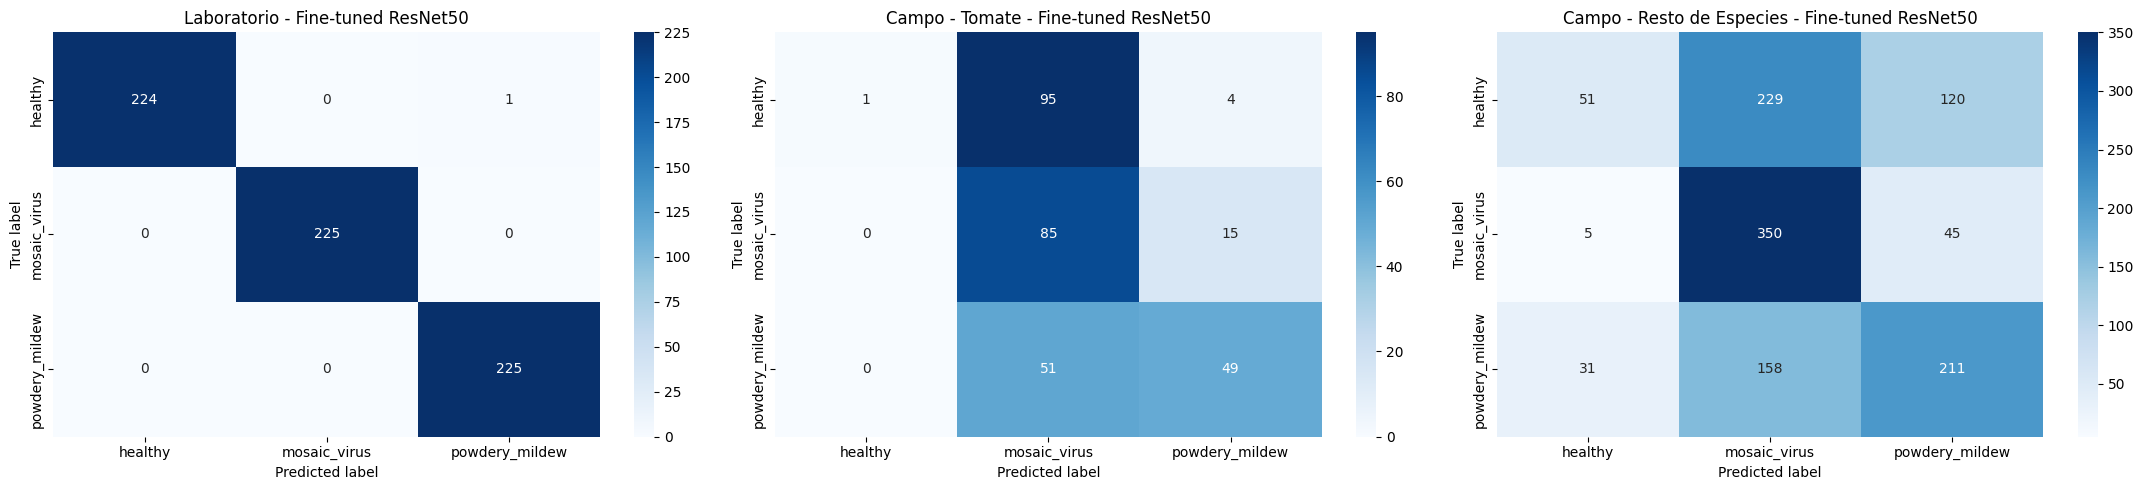


Resultados guardados en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/ResNet50_fine_tuned_results_final_ex2.csv


Dominio  Accuracy
0                Laboratorio  0.998519
1             Campo - Tomate  0.450000
2  Campo - Resto de Especies  0.510000

In [ ]:
# Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
datasets = [
    ("Laboratorio", confusion_matrix(y_true_lab, y_pred_lab)),
    ("Campo - Tomate", confusion_matrix(y_true_field_tomato, y_pred_field_tomato)),
    ("Campo - Resto de Especies", confusion_matrix(y_true_field_species, y_pred_field_species))]

for ax, (title, cm) in zip(axes, datasets):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES, ax=ax)
    ax.set_title(f"{title} - Fine-tuned ResNet50")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

# Guardar métricas resumidas
df_eval_ft = pd.DataFrame({
    "Dominio": ["Laboratorio",
                "Campo - Tomate",
                "Campo - Resto de Especies"],
    "Accuracy": [acc_lab,
                 acc_field_tomato,
                 acc_field_species]})

out_csv = os.path.join(RESULTS_PATH, "ResNet50_fine_tuned_results_final_ex2.csv")
df_eval_ft.to_csv(out_csv, index=False)
print(f"\nResultados guardados en: {out_csv}")
display(df_eval_ft)

## <font color="orange"><font size="5"> **5.3.- Grad-CAM**

In [ ]:
# Ejemplo 1: evaluar grad-CAM sobre imagen de "healthy"
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

gradcam_simple(model, "/content/dataset/bell_pepper/field/healthy/seg_bell_pepper_field_healthy_dataset05_image001.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="healthy")
gradcam_simple(model, "/content/dataset/cucumber/field/healthy/seg_cucumber_field_healthy_dataset21_image030.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="healthy")
gradcam_simple(model, "/content/dataset/eggplant/field/healthy/seg_eggplant_field_healthy_dataset16_image037.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="healthy")
gradcam_simple(model, "/content/dataset/pumpkin/field/healthy/seg_pumpkin_field_healthy_dataset08_image050.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="healthy")
gradcam_simple(model, "/content/dataset/tomato/field/healthy/seg_tomato_field_healthy_dataset04_image006.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="healthy")
gradcam_simple(model, "/content/dataset/tomato/lab/healthy/seg_tomato_lab_healthy_dataset01_image0086.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="healthy")

Output hidden; open in https://colab.research.google.com to view.

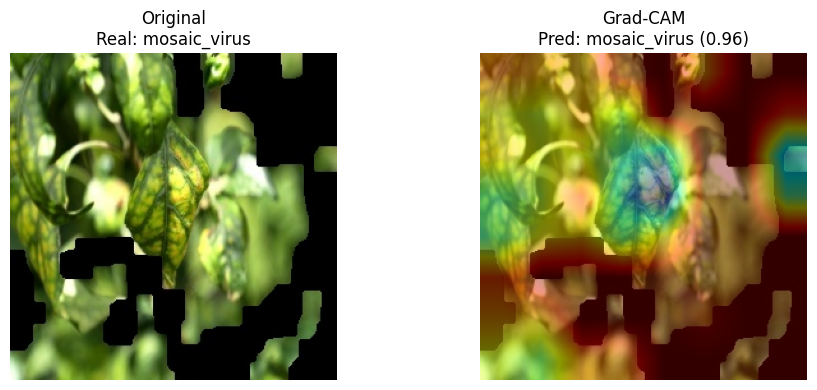

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_bell_pepper_mosaic_virus_seg_bell_pepper_field_mosaic_virus_dataset07_image011_pred-mosaic_virus_final_ex2.jpg


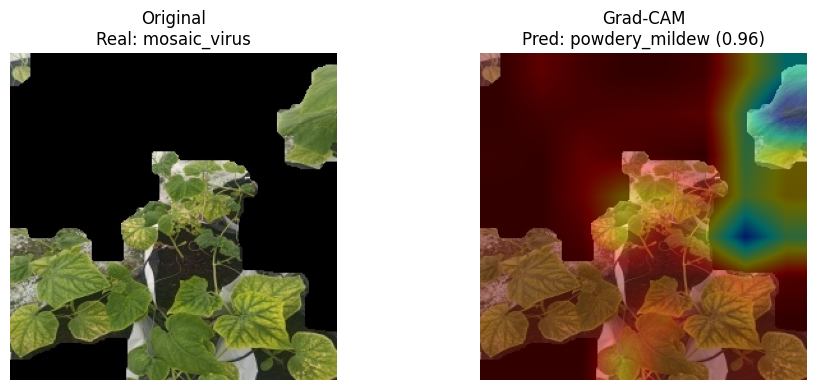

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_cucumber_mosaic_virus_seg_cucumber_field_mosaic_virus_dataset24_image100_pred-powdery_mildew_final_ex2.jpg


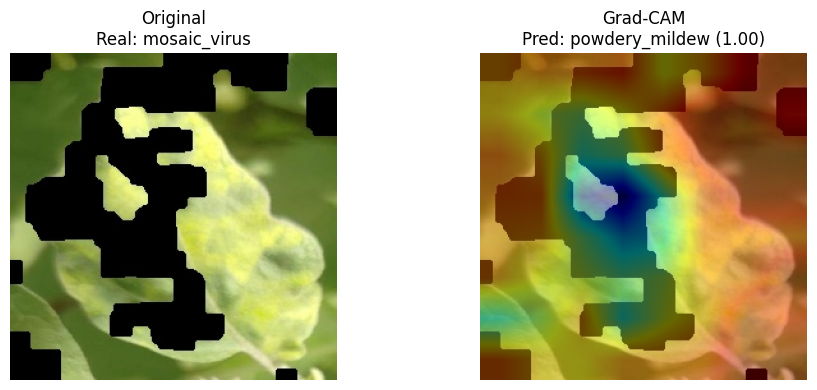

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_eggplant_mosaic_virus_seg_eggplant_field_mosaic_virus_dataset16_image063_pred-powdery_mildew_final_ex2.jpg


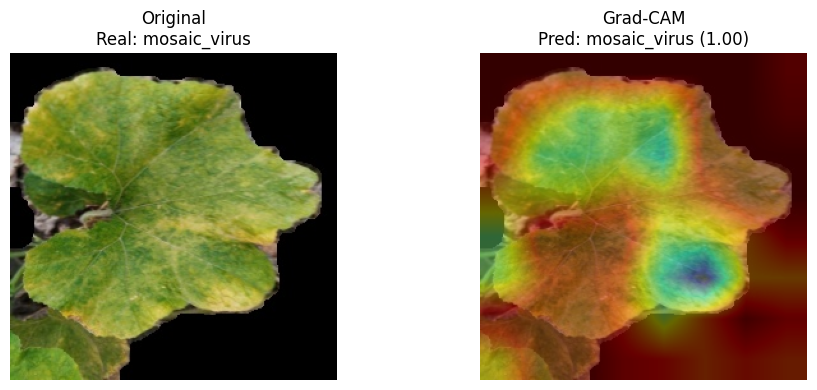

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_pumpkin_mosaic_virus_seg_pumpkin_field_mosaic_virus_dataset08_image096_pred-mosaic_virus_final_ex2.jpg


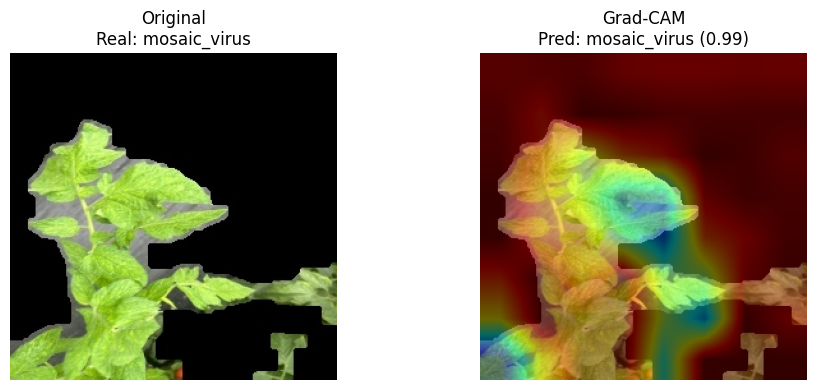

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_tomato_mosaic_virus_seg_tomato_field_mosaic_virus_dataset11_image081_pred-mosaic_virus_final_ex2.jpg


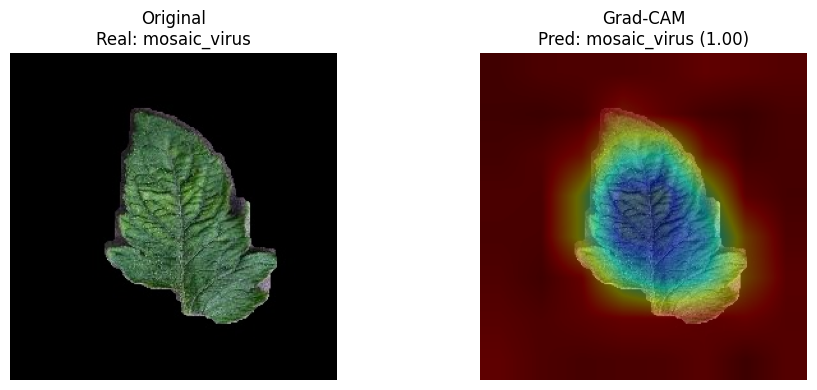

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_tomato-lab_mosaic_virus_seg_tomato_lab_mosaic_virus_dataset25_image0012_pred-mosaic_virus_final_ex2.jpg


In [ ]:
# Ejemplo 2: evaluar grad-CAM sobre imagen de "mosaic_virus"

gradcam_simple(model, "/content/dataset/bell_pepper/field/mosaic_virus/seg_bell_pepper_field_mosaic_virus_dataset07_image011.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="mosaic_virus")
gradcam_simple(model, "/content/dataset/cucumber/field/mosaic_virus/seg_cucumber_field_mosaic_virus_dataset24_image100.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="mosaic_virus")
gradcam_simple(model, "/content/dataset/eggplant/field/mosaic_virus/seg_eggplant_field_mosaic_virus_dataset16_image063.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="mosaic_virus")
gradcam_simple(model, "/content/dataset/pumpkin/field/mosaic_virus/seg_pumpkin_field_mosaic_virus_dataset08_image096.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="mosaic_virus")
gradcam_simple(model, "/content/dataset/tomato/field/mosaic_virus/seg_tomato_field_mosaic_virus_dataset11_image081.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="mosaic_virus")
gradcam_simple(model, "/content/dataset/tomato/lab/mosaic_virus/seg_tomato_lab_mosaic_virus_dataset25_image0012.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="mosaic_virus")

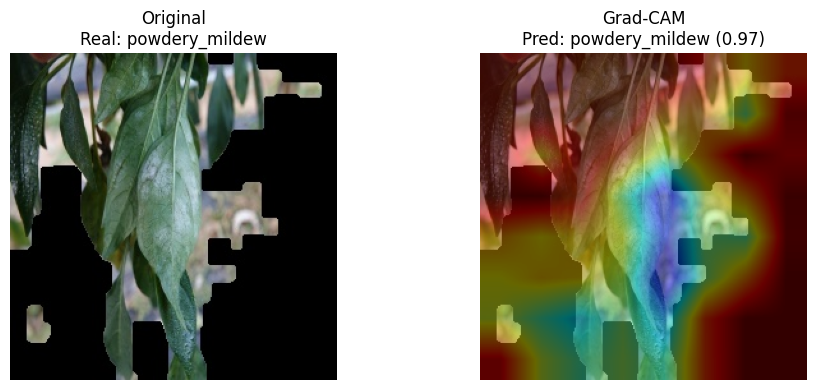

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_bell_pepper_powdery_mildew_seg_bell_pepper_field_powdery_mildew_dataset12_image015_pred-powdery_mildew_final_ex2.jpg


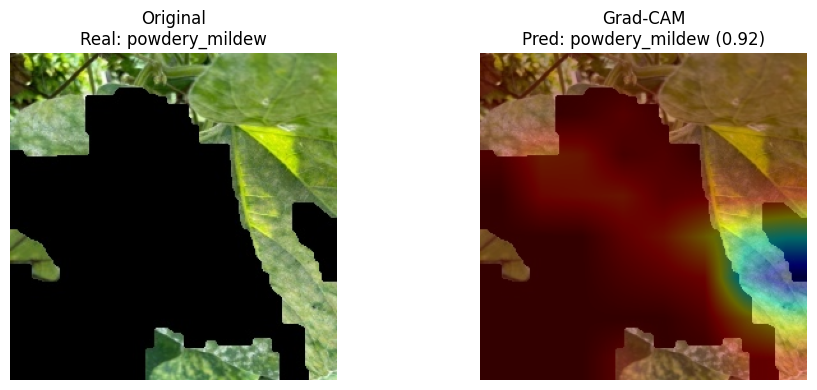

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_cucumber_powdery_mildew_seg_cucumber_field_powdery_mildew_dataset22_image048_pred-powdery_mildew_final_ex2.jpg


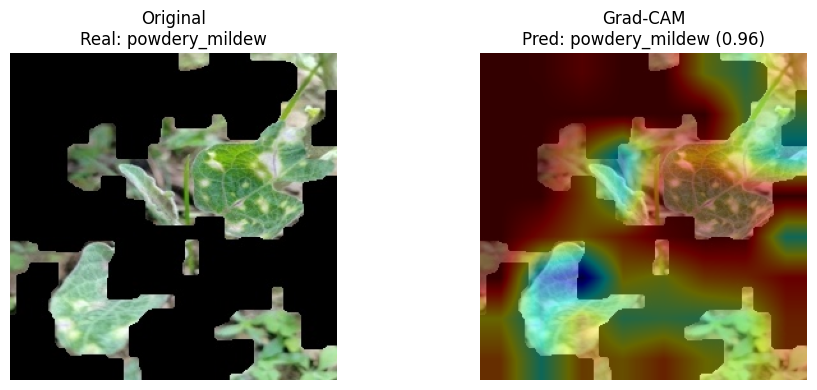

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_eggplant_powdery_mildew_seg_eggplant_field_powdery_mildew_dataset16_image018_pred-powdery_mildew_final_ex2.jpg


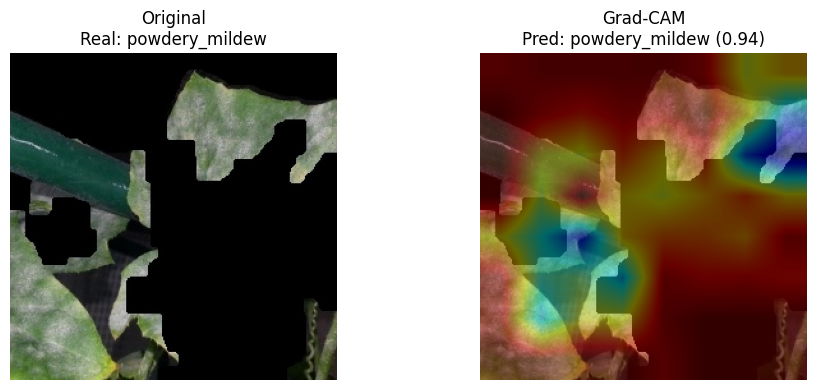

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_pumpkin_powdery_mildew_seg_pumpkin_field_powdery_mildew_dataset03_image012_pred-powdery_mildew_final_ex2.jpg


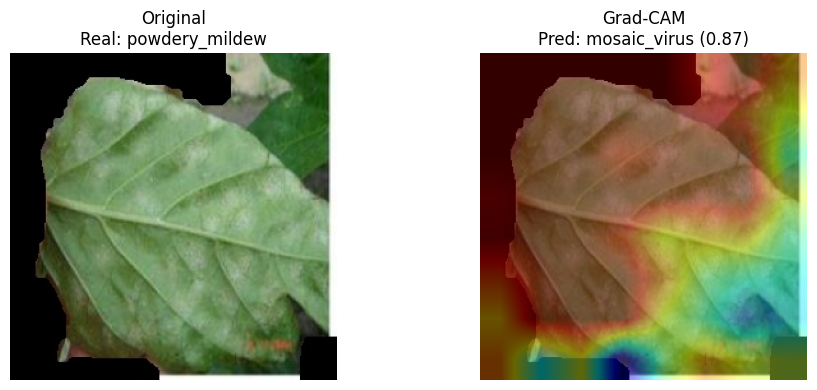

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_tomato_powdery_mildew_seg_tomato_field_powdery_mildew_dataset04_image017_pred-mosaic_virus_final_ex2.jpg


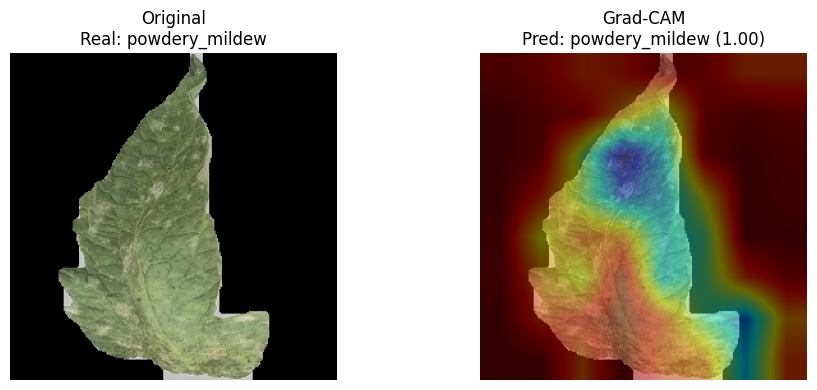

Imagen Grad-CAM guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/resnet50/resnet50_tomato-lab_powdery_mildew_seg_tomato_lab_powdery_mildew_dataset02_image0002_pred-powdery_mildew_final_ex2.jpg


In [ ]:
# Ejemplo 3: evaluar grad-CAM sobre imagen de "powdery_mildew"

gradcam_simple(model, "/content/dataset/bell_pepper/field/powdery_mildew/seg_bell_pepper_field_powdery_mildew_dataset12_image015.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="powdery_mildew")
gradcam_simple(model, "/content/dataset/cucumber/field/powdery_mildew/seg_cucumber_field_powdery_mildew_dataset22_image048.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="powdery_mildew")
gradcam_simple(model, "/content/dataset/eggplant/field/powdery_mildew/seg_eggplant_field_powdery_mildew_dataset16_image018.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="powdery_mildew")
gradcam_simple(model, "/content/dataset/pumpkin/field/powdery_mildew/seg_pumpkin_field_powdery_mildew_dataset03_image012.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="powdery_mildew")
gradcam_simple(model, "/content/dataset/tomato/field/powdery_mildew/seg_tomato_field_powdery_mildew_dataset04_image017.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="powdery_mildew")
gradcam_simple(model, "/content/dataset/tomato/lab/powdery_mildew/seg_tomato_lab_powdery_mildew_dataset02_image0002.jpg",
               base_model_name="resnet50", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="powdery_mildew")

# <font color="orange"><font size="7"> **6.- MODELO END-TO-END**

## <font color="orange"><font size="5"> **6.1.- Modelo con transfer learning**

### <font color="orange"><font size="4"> ***6.1.1.- Selección de la arquitectura de DL***

In [ ]:
base_model_e2e = "ResNet50"

### <font color="orange"><font size="4"> ***6.1.2.- Data Augmentation***

In [ ]:
# Librerías
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

# Clases (2 enfermedades + clase de salud)
CLASSES = ['healthy', 'mosaic_virus', 'powdery_mildew']

# Parámetros
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32

# Modelo seleccionado
base_model_name = base_model_e2e
preprocess_model = preprocess_resnet50

# Generar datos para entrenamiento
train_datagen_e2e = ImageDataGenerator(
    preprocessing_function=preprocess_model,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True)

train_generator_e2e = train_datagen_e2e.flow_from_dataframe(
    dataframe=train_lab_no_seg,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42)

# Generador de datos para validación
val_datagen_e2e = ImageDataGenerator(preprocessing_function=preprocess_model)
val_generator_e2e = val_datagen_e2e.flow_from_dataframe(
    dataframe=val_lab_no_seg,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# Generador de datos para test
# --> Test con imágenes de laboratorio (test_lab)
test_datagen_e2e = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_e2e = test_datagen_e2e.flow_from_dataframe(
    dataframe=test_lab_no_seg,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de tomate (test_field_tomato)
test_datagen_field_tomato_e2e = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_field_tomato_e2e = test_datagen_field_tomato_e2e.flow_from_dataframe(
    dataframe=test_field_tomato_no_seg,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

# --> Test con imágenes de campo de otras especies (test_field_species)
test_datagen_field_species_e2e = ImageDataGenerator(preprocessing_function=preprocess_model)
test_generator_field_species_e2e = test_datagen_field_species_e2e.flow_from_dataframe(
    dataframe=test_field_species_no_seg,
    x_col='full_path',
    y_col='class',
    target_size=TARGET_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42)

print("Generadores creados correctamente.")

Found 3150 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
Generadores creados correctamente.


### <font color="orange"><font size="4"> ***6.1.3.-Construir modelo base y compilarlo***

In [ ]:
# Hiperparámetros (los mismos que de ResNet50 entrenado con imágenes segmentadas)
learning_rate_e2e = 0.001
dense_units_e2e = 128
dropout_rate_e2e = 0.5
optimizer_e2e = "adam"

# Generar y mostrar el modelo
model_e2e = build_model("ResNet50", learning_rate_e2e, dense_units_e2e, dropout_rate_e2e, optimizer_e2e)
model_e2e.summary()

# Visualización del modelo
tf.keras.utils.plot_model(model_e2e, to_file=os.path.join(RESULTS_PATH_no_seg, "e2e_ResNet50_architecture_final_ex2.jpg"), show_shapes=True)

# Guardar versión compilada (previa al fine-tuning)
initial_model_path_e2e = os.path.join(RESULTS_PATH_no_seg, "e2e_ResNet50_frozen_base_final_ex2.h5")
model_e2e.save(initial_model_path_e2e)
print(f"Modelo guardado en: {initial_model_path_e2e}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,883 (90.98 MB)

 Trainable params: 262,915 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/e2e_ResNet50_frozen_base_final_ex2.h5


### <font color="orange"><font size="4"> ***6.1.4.- Entrenar el modelo***

In [ ]:
# Librerías
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

# Modelo base y ruta de guardado
base_model_e2e = "ResNet50"
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_DIR_e2e = os.path.join(RESULTS_PATH_no_seg, base_model_e2e)
os.makedirs(MODEL_DIR_e2e, exist_ok=True)

# Definir parámetros de los callbacks
callbacks_e2e = [
    EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3,
        restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-6, verbose=1)]

tf.keras.backend.clear_session() # liberar memoria de la GPU

# Entrenamiento Modelo 1
H_e2e = model_e2e.fit(
    train_generator_e2e,
    validation_data=val_generator_e2e,
    epochs=25,
    batch_size=32,
    callbacks=callbacks_e2e,
    verbose=1)

# Guardado del historial del modelo
hist_df_e2e = pd.DataFrame(H_e2e.history)
hist_df_e2e.to_csv(os.path.join(MODEL_DIR_e2e, f"e2e_{base_model_e2e}_training_history_final_ex2_{timestamp}.csv"), index=False)

# Guardado del modelo final
final_model_path_e2e = os.path.join(MODEL_DIR_e2e, f"e2e_{base_model_e2e}_final-model_final_ex2_{timestamp}.h5")
model_e2e.save(final_model_path_e2e)

print(f"\nEntrenamiento completado.")
print("-----------------------------------------------------------------------")
print(f"Modelo final guardado en: {final_model_path_e2e}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 70s 599ms/step - accuracy: 0.9536 - loss: 0.1315 - val_accuracy: 0.9956 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 502ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9941 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 508ms/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9881 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9996 - loss: 0.0036
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 51s 512ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.9956 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.



Entrenamiento completado.
-----------------------------------------------------------------------
Modelo final guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/MobileNetV2/e2e_MobileNetV2_final-model_final_ex2_20251101_1712.h5


## <font color="orange"><font size="5"> **6.2.- Resultados modelo con transfer learning**

### <font color="orange"><font size="4"> ***6.2.1.- Learning curves***

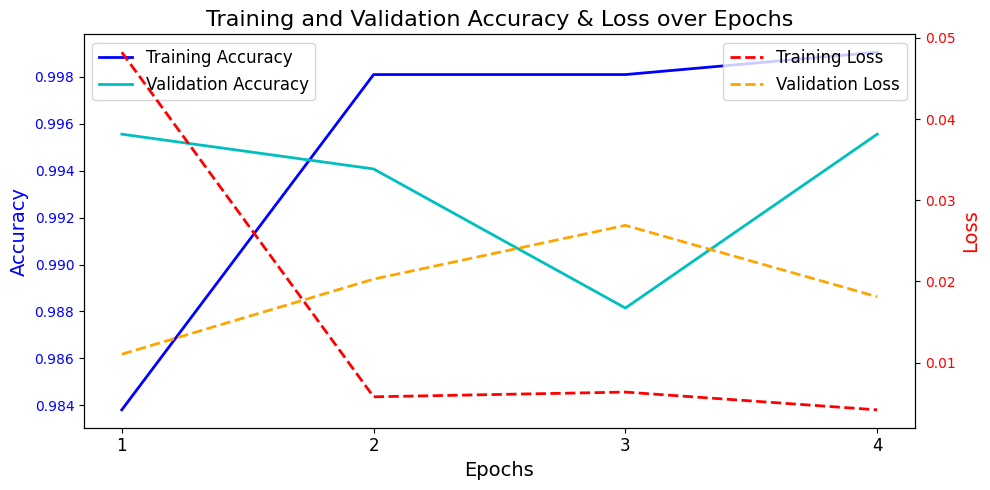

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.arange(1, len(H_e2e.history['accuracy']) + 1),
         H_e2e.history['accuracy'], label='Training Accuracy', color='b',
         linewidth=2)
ax1.plot(np.arange(1, len(H_e2e.history['val_accuracy']) + 1),
         H_e2e.history['val_accuracy'], label='Validation Accuracy',
         color='c', linewidth=2)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xticks(np.arange(1, len(H_e2e.history['accuracy']) + 1, 1))
ax2 = ax1.twinx()
ax2.plot(np.arange(1, len(H_e2e.history['loss']) + 1),
         H_e2e.history['loss'], label='Training Loss', color='r',
         linewidth=2, linestyle='--')
ax2.plot(np.arange(1, len(H_e2e.history['val_loss']) + 1),
         H_e2e.history['val_loss'], label='Validation Loss',
         color='orange', linewidth=2, linestyle='--')
ax2.set_ylabel('Loss', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='r')
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
plt.title('Training and Validation Accuracy & Loss over Epochs', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH_no_seg, "e2e_learning_curves_lab_final_ex2.jpg"))
plt.show()

### <font color="orange"><font size="4"> ***6.2.2.- Resultados con imágenes de laboratorio***

<font color="orange"><font size="3"> *Métricas*

In [ ]:
# Métricas
preds_test_e2e, y_true_test_e2e, y_pred_test_e2e = evaluate_model(model_e2e, test_generator_e2e, "Test")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step

Resultados para Test:
                precision    recall  f1-score   support

       healthy     0.9868    1.0000    0.9934       225
  mosaic_virus     1.0000    0.9867    0.9933       225
powdery_mildew     1.0000    1.0000    1.0000       225

      accuracy                         0.9956       675
     macro avg     0.9956    0.9956    0.9956       675
  weighted avg     0.9956    0.9956    0.9956       675


Accuracy total: 0.9956


<font color="orange"><font size="3"> *Matriz de confusión*

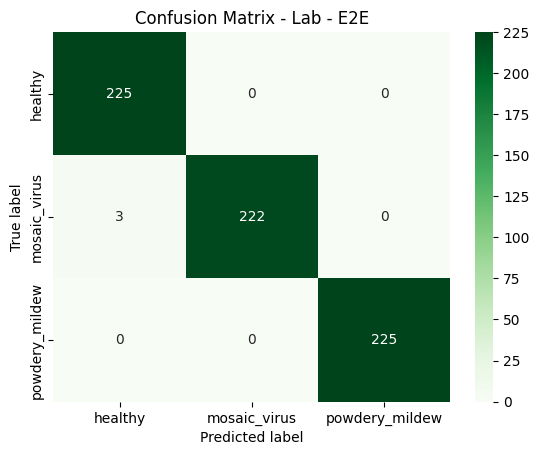

In [ ]:
#Librerías
from sklearn.metrics import (confusion_matrix)
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Generar matriz de confusión
cm_e2e = confusion_matrix(y_true_test_e2e, y_pred_test_e2e)

sns.heatmap(cm_e2e, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES)
colorbar = plt.gca().collections[0].colorbar
colorbar.locator = MaxNLocator(integer=True)
colorbar.update_ticks()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Lab - E2E")

# Guardar matriz de confusión
model_name_e2e="MobileNetV2"
plt.savefig(os.path.join(RESULTS_PATH_no_seg, f"e2e_cm_lab_final_ex2_{model_name_e2e}.jpg"))

### <font color="orange"><font size="4"> ***6.2.3.- Resultados con imágenes de campo***

<font color="orange"><font size="3"> *Predicciones*

In [ ]:
# Predicciones con imágenes de campo de tomate
preds_tomato_e2e = model_e2e.predict(test_generator_field_tomato_e2e, verbose=1)
y_true_tomato_e2e = test_generator_field_tomato_e2e.classes
y_pred_tomato_e2e = np.argmax(preds_tomato_e2e, axis=1)
class_labels_tomato_e2e = list(test_generator_field_tomato_e2e.class_indices.keys())

# Predicciones con imágenes de campo del resto de plantas
preds_species_e2e = model_e2e.predict(test_generator_field_species_e2e, verbose=1)
y_true_species_e2e = test_generator_field_species_e2e.classes
y_pred_species_e2e = np.argmax(preds_species_e2e, axis=1)
class_labels_species_e2e = list(test_generator_field_species_e2e.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


<font color="orange"><font size="3"> *Métricas*

In [ ]:
# Métricas tomate
print("\nResultados para imágenes de campo de tomate - E2E:")
print(classification_report(y_true_tomato_e2e, y_pred_tomato_e2e, target_names=class_labels_tomato_e2e, digits=4))

acc_tomato_e2e = accuracy_score(y_true_tomato_e2e, y_pred_tomato_e2e)
print(f"Accuracy total: {acc_tomato_e2e:.4f}")


Resultados para imágenes de campo de tomate - E2E:
                precision    recall  f1-score   support

       healthy     0.6509    0.6900    0.6699       100
  mosaic_virus     0.0800    0.0200    0.0320       100
powdery_mildew     0.4260    0.7200    0.5353       100

      accuracy                         0.4767       300
     macro avg     0.3857    0.4767    0.4124       300
  weighted avg     0.3857    0.4767    0.4124       300

Accuracy total: 0.4767


In [ ]:
# Métricas resto de plantas
print("\nResultados para imágenes de campo del resto de plantas - E2E:")
print(classification_report(y_true_species_e2e, y_pred_species_e2e, target_names=class_labels_species_e2e, digits=4))

acc_species_e2e = accuracy_score(y_true_species_e2e, y_pred_species_e2e)
print(f"Accuracy total: {acc_species_e2e:.4f}")


Resultados para imágenes de campo del resto de plantas - E2E:
                precision    recall  f1-score   support

       healthy     0.5908    0.7075    0.6439       400
  mosaic_virus     0.9167    0.1100    0.1964       400
powdery_mildew     0.3848    0.6475    0.4828       400

      accuracy                         0.4883      1200
     macro avg     0.6308    0.4883    0.4410      1200
  weighted avg     0.6308    0.4883    0.4410      1200

Accuracy total: 0.4883


<font color="orange"><font size="3"> *Matriz de confusión*

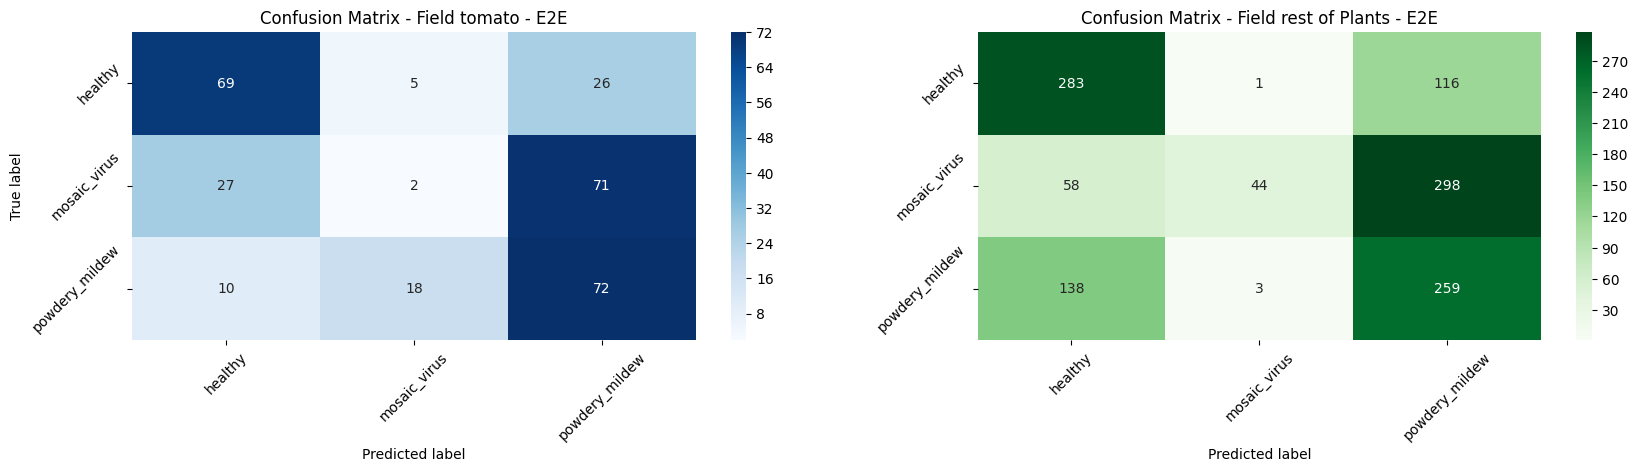

In [ ]:
# Generar matrices de confusión
cm_tomato_e2e = confusion_matrix(y_true_tomato_e2e, y_pred_tomato_e2e)
cm_species_e2e = confusion_matrix(y_true_species_e2e, y_pred_species_e2e)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Matriz de confusión tomate
ax1 = sns.heatmap(cm_tomato_e2e, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
colorbar1 = ax1.collections[0].colorbar
colorbar1.locator = MaxNLocator(integer=True)
colorbar1.update_ticks()
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_title("Confusion Matrix - Field tomato - E2E")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=45)

# Matriz de confusión resto de plantas
ax2 = sns.heatmap(cm_species_e2e, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
colorbar2 = ax2.collections[0].colorbar
colorbar2.locator = MaxNLocator(integer=True)
colorbar2.update_ticks()
axes[1].set_xlabel("Predicted label")
axes[1].set_title("Confusion Matrix - Field rest of Plants - E2E")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=45)

# Guardar matriz de confusión
model_name_e2e="EfficientNetB0"
plt.savefig(os.path.join(RESULTS_PATH_no_seg, f"e2e_cm_field_final_ex2_{model_name_e2e}.jpg"))

<font color="orange"><font size="3"> *Observar imágenes mal clasificadas*



In [ ]:
# Mostrar resultado de las primeras 15 imágenes
df_tomato_e2e = build_results_table(test_generator_field_tomato_e2e, preds_tomato_e2e, y_true_tomato_e2e, y_pred_tomato_e2e, class_labels_tomato_e2e, "e2e", "CampoTomate", RESULTS_PATH_no_seg)
df_species_e2e = build_results_table(test_generator_field_species_e2e, preds_species_e2e, y_true_species_e2e, y_pred_species_e2e, class_labels_species_e2e, "e2e", "CampoEspecies", RESULTS_PATH_no_seg)


Resultados detallados - e2e (CampoTomate):


Imagen Clase correcta  \
0   tomato_field_healthy_dataset04_image001.jpg        healthy   
1   tomato_field_healthy_dataset04_image002.jpg        healthy   
2   tomato_field_healthy_dataset04_image003.jpg        healthy   
3   tomato_field_healthy_dataset04_image004.jpg        healthy   
4   tomato_field_healthy_dataset04_image005.jpg        healthy   
5   tomato_field_healthy_dataset04_image006.jpg        healthy   
6   tomato_field_healthy_dataset04_image007.jpg        healthy   
7   tomato_field_healthy_dataset04_image008.jpg        healthy   
8   tomato_field_healthy_dataset04_image009.jpg        healthy   
9   tomato_field_healthy_dataset04_image010.jpg        healthy   
10  tomato_field_healthy_dataset04_image011.jpg        healthy   
11  tomato_field_healthy_dataset04_image012.jpg        healthy   
12  tomato_field_healthy_dataset04_image013.jpg        healthy   
13  tomato_field_healthy_dataset04_image014.jpg        healthy   
14  tomato_field_healthy_dataset04_image015.jpg        healthy   

    Clase predicha  Probabilidad Acierto  
0   powdery_mildew      0.516815      no  
1   powdery_mildew      0.655359      no  
2   powdery_mildew      0.609717      no  
3   powdery_mildew      0.810918      no  
4          healthy      0.511345      si  
5          healthy      0.847569      si  
6          healthy      0.700254      si  
7   powdery_mildew      0.518685      no  
8     mosaic_virus      0.440294      no  
9          healthy      0.624724      si  
10    mosaic_virus      0.384460      no  
11  powdery_mildew      0.530801      no  
12  powdery_mildew      0.487142      no  
13         healthy      0.894176      si  
14         healthy      0.537291      si


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/predicciones_e2e_final_ex2_CampoTomate.csv

Resumen de aciertos por clase:


Acierto         no  si
Clase correcta        
healthy         31  69
mosaic_virus    98   2
powdery_mildew  28  72


Resultados detallados - e2e (CampoEspecies):


Imagen Clase correcta  \
0   bell_pepper_field_healthy_dataset05_image001.jpg        healthy   
1   bell_pepper_field_healthy_dataset05_image002.jpg        healthy   
2   bell_pepper_field_healthy_dataset05_image003.jpg        healthy   
3   bell_pepper_field_healthy_dataset05_image004.jpg        healthy   
4   bell_pepper_field_healthy_dataset05_image005.jpg        healthy   
5   bell_pepper_field_healthy_dataset05_image006.jpg        healthy   
6   bell_pepper_field_healthy_dataset05_image007.jpg        healthy   
7   bell_pepper_field_healthy_dataset05_image008.jpg        healthy   
8   bell_pepper_field_healthy_dataset05_image009.jpg        healthy   
9   bell_pepper_field_healthy_dataset05_image010.jpg        healthy   
10  bell_pepper_field_healthy_dataset05_image011.jpg        healthy   
11  bell_pepper_field_healthy_dataset05_image012.jpg        healthy   
12  bell_pepper_field_healthy_dataset05_image013.jpg        healthy   
13  bell_pepper_field_healthy_dataset05_image014.jpg        healthy   
14  bell_pepper_field_healthy_dataset05_image015.jpg        healthy   

    Clase predicha  Probabilidad Acierto  
0          healthy      0.919585      si  
1          healthy      0.596368      si  
2          healthy      0.938452      si  
3          healthy      0.988494      si  
4          healthy      0.908897      si  
5   powdery_mildew      0.742338      no  
6          healthy      0.987668      si  
7          healthy      0.999013      si  
8          healthy      0.991465      si  
9          healthy      0.964768      si  
10         healthy      0.591729      si  
11         healthy      0.996404      si  
12         healthy      0.807411      si  
13         healthy      0.748194      si  
14         healthy      0.820962      si


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/predicciones_e2e_final_ex2_CampoEspecies.csv

Resumen de aciertos por clase:


Acierto          no   si
Clase correcta          
healthy         117  283
mosaic_virus    356   44
powdery_mildew  141  259

In [ ]:
# Mostrar imágenes mal clasificadas
mostrar_mal_clasificadas(test_generator_field_tomato_e2e, preds_tomato_e2e, y_true_tomato_e2e, y_pred_tomato_e2e, class_labels_tomato_e2e, "e2e", "Campotomate", n_mostrar=15, RESULTS_PATH=RESULTS_PATH_no_seg)
mostrar_mal_clasificadas(test_generator_field_species_e2e, preds_species_e2e, y_true_species_e2e, y_pred_species_e2e, class_labels_species_e2e, "e2e", "CampoEspecies", n_mostrar=15, RESULTS_PATH=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

### <font color="orange"><font size="4"> ***6.2.4.- Resultados Grad-CAM***

In [ ]:
# Ejemplo 1: evaluar grad-CAM sobre imagen de "healthy"
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

gradcam_simple(model_e2e, "/content/dataset_no_seg/bell_pepper/field/healthy/bell_pepper_field_healthy_dataset05_image001.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/cucumber/field/healthy/cucumber_field_healthy_dataset21_image030.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/eggplant/field/healthy/eggplant_field_healthy_dataset16_image037.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/pumpkin/field/healthy/pumpkin_field_healthy_dataset08_image050.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/tomato/field/healthy/tomato_field_healthy_dataset04_image006.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/tomato/lab/healthy/tomato_lab_healthy_dataset01_image0086.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ejemplo 2: evaluar grad-CAM sobre imagen de "mosaic_virus"

gradcam_simple(model_e2e, "/content/dataset_no_seg/bell_pepper/field/mosaic_virus/bell_pepper_field_mosaic_virus_dataset07_image011.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/cucumber/field/mosaic_virus/cucumber_field_mosaic_virus_dataset24_image100.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/eggplant/field/mosaic_virus/eggplant_field_mosaic_virus_dataset16_image063.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/pumpkin/field/mosaic_virus/pumpkin_field_mosaic_virus_dataset08_image096.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/tomato/field/mosaic_virus/tomato_field_mosaic_virus_dataset11_image081.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/tomato/lab/mosaic_virus/tomato_lab_mosaic_virus_dataset25_image0012.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ejemplo 3: evaluar grad-CAM sobre imagen de "powdery_mildew"

gradcam_simple(model_e2e, "/content/dataset_no_seg/bell_pepper/field/powdery_mildew/bell_pepper_field_powdery_mildew_dataset12_image015.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/cucumber/field/powdery_mildew/cucumber_field_powdery_mildew_dataset22_image048.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/eggplant/field/powdery_mildew/eggplant_field_powdery_mildew_dataset16_image018.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/pumpkin/field/powdery_mildew/pumpkin_field_powdery_mildew_dataset03_image012.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/tomato/field/powdery_mildew/tomato_field_powdery_mildew_dataset04_image017.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_e2e, "/content/dataset_no_seg/tomato/lab/powdery_mildew/tomato_lab_powdery_mildew_dataset02_image0002.jpg",
               base_model_name="e2e", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

## <font color="orange"><font size="5"> **6.3.- Modelo con fine-tuning**

In [ ]:
# Aplicar Fine-tuning al modelo e2e
model_ft_e2e, history_ft_e2e = fine_tune_model(model_e2e, train_generator_e2e, val_generator_e2e, fine_tune_at=50,
                                    model_name="e2e", results_path=RESULTS_PATH_no_seg)

50 capas descongeladas para fine-tuning.
Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 652ms/step - accuracy: 0.9989 - loss: 0.0099 - val_accuracy: 0.9970 - val_loss: 0.0075 - learning_rate: 5.0000e-06
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.9997 - loss: 0.0067 - val_accuracy: 0.9970 - val_loss: 0.0064 - learning_rate: 5.0000e-06
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 51s 516ms/step - accuracy: 0.9998 - loss: 0.0050 - val_accuracy: 0.9985 - val_loss: 0.0049 - learning_rate: 5.0000e-06
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 502ms/step - accuracy: 0.9995 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 5.0000e-06
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 509ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 5.0000e-06
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 509ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 8.7267e-04 - learning_rate: 5.0000e-06
Epoch 7/15
99


Fine-tuning completado.
Guardados:
- Final: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/e2e/e2e_fine_tuned_final_ex2_20251101_1716.h5


## <font color="orange"><font size="5"> **6.4.- Resultados modelo con fine-tuning**

### <font color="orange"><font size="4"> ***6.4.1.- Resultados con imágenes de laboratorio***

<font color="orange"><font size="3"> *Métricas*

In [ ]:
# Métricas
preds_test_ft_e2e, y_true_test_ft_e2e, y_pred_test_ft_e2e = evaluate_model(model_ft_e2e, test_generator_e2e, "Test")

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step

Resultados para Test:
                precision    recall  f1-score   support

       healthy     1.0000    1.0000    1.0000       225
  mosaic_virus     1.0000    1.0000    1.0000       225
powdery_mildew     1.0000    1.0000    1.0000       225

      accuracy                         1.0000       675
     macro avg     1.0000    1.0000    1.0000       675
  weighted avg     1.0000    1.0000    1.0000       675


Accuracy total: 1.0000


<font color="orange"><font size="3"> *Matriz de confusión*

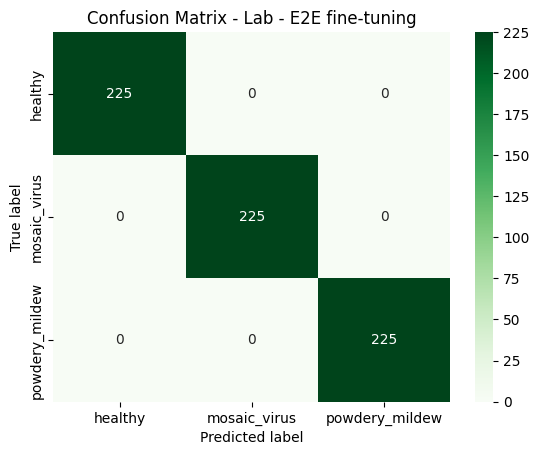

In [ ]:
#Librerías
from sklearn.metrics import (confusion_matrix)
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Generar matriz de confusión
cm_ft_e2e = confusion_matrix(y_true_test_ft_e2e, y_pred_test_ft_e2e)

sns.heatmap(cm_ft_e2e, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES)
colorbar = plt.gca().collections[0].colorbar
colorbar.locator = MaxNLocator(integer=True)
colorbar.update_ticks()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Lab - E2E fine-tuning")

# Guardar matriz de confusión
model_name_e2e="EfficientNetB0"
plt.savefig(os.path.join(RESULTS_PATH_no_seg, f"e2e_ft_cm_lab_final_ex2_{model_name_e2e}.jpg"))

### <font color="orange"><font size="4"> ***6.4.2.- Resultados con imágenes de campo***

<font color="orange"><font size="3"> *Predicciones*

In [ ]:
# Predicciones con imágenes de campo de tomate
preds_tomato_ft_e2e = model_ft_e2e.predict(test_generator_field_tomato_e2e, verbose=1)
y_true_tomato_ft_e2e = test_generator_field_tomato_e2e.classes
y_pred_tomato_ft_e2e = np.argmax(preds_tomato_ft_e2e, axis=1)
class_labels_tomato_ft_e2e = list(test_generator_field_tomato_e2e.class_indices.keys())

# Predicciones con imágenes de campo del resto de plantas
preds_species_ft_e2e = model_ft_e2e.predict(test_generator_field_species_e2e, verbose=1)
y_true_species_ft_e2e = test_generator_field_species_e2e.classes
y_pred_species_ft_e2e = np.argmax(preds_species_ft_e2e, axis=1)
class_labels_species_ft_e2e = list(test_generator_field_species_e2e.class_indices.keys())

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


<font color="orange"><font size="3"> *Métricas*

In [ ]:
# Métricas tomate
print("\nResultados para imágenes de campo de tomate - E2E fine-tuning:")
print(classification_report(y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e, target_names=class_labels_tomato_ft_e2e, digits=4))

acc_tomato_ft_e2e = accuracy_score(y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e)
print(f"Accuracy total: {acc_tomato_ft_e2e:.4f}")


Resultados para imágenes de campo de tomate - E2E fine-tuning:
                precision    recall  f1-score   support

       healthy     0.4755    0.6800    0.5597       100
  mosaic_virus     0.0562    0.0500    0.0529       100
powdery_mildew     0.4706    0.3200    0.3810       100

      accuracy                         0.3500       300
     macro avg     0.3341    0.3500    0.3312       300
  weighted avg     0.3341    0.3500    0.3312       300

Accuracy total: 0.3500


In [ ]:
# Métricas resto de plantas
print("\nResultados para imágenes de campo del resto de plantas - E2E fine-tuning:")
print(classification_report(y_true_species_ft_e2e, y_pred_species_ft_e2e, target_names=class_labels_species_ft_e2e, digits=4))

acc_species_ft_e2e = accuracy_score(y_true_species_ft_e2e, y_pred_species_ft_e2e)
print(f"Accuracy total: {acc_species_ft_e2e:.4f}")


Resultados para imágenes de campo del resto de plantas - E2E fine-tuning:
                precision    recall  f1-score   support

       healthy     0.5598    0.7375    0.6365       400
  mosaic_virus     0.8290    0.5575    0.6667       400
powdery_mildew     0.5149    0.5200    0.5174       400

      accuracy                         0.6050      1200
     macro avg     0.6345    0.6050    0.6068      1200
  weighted avg     0.6345    0.6050    0.6068      1200

Accuracy total: 0.6050


<font color="orange"><font size="3"> *Matriz de confusión*

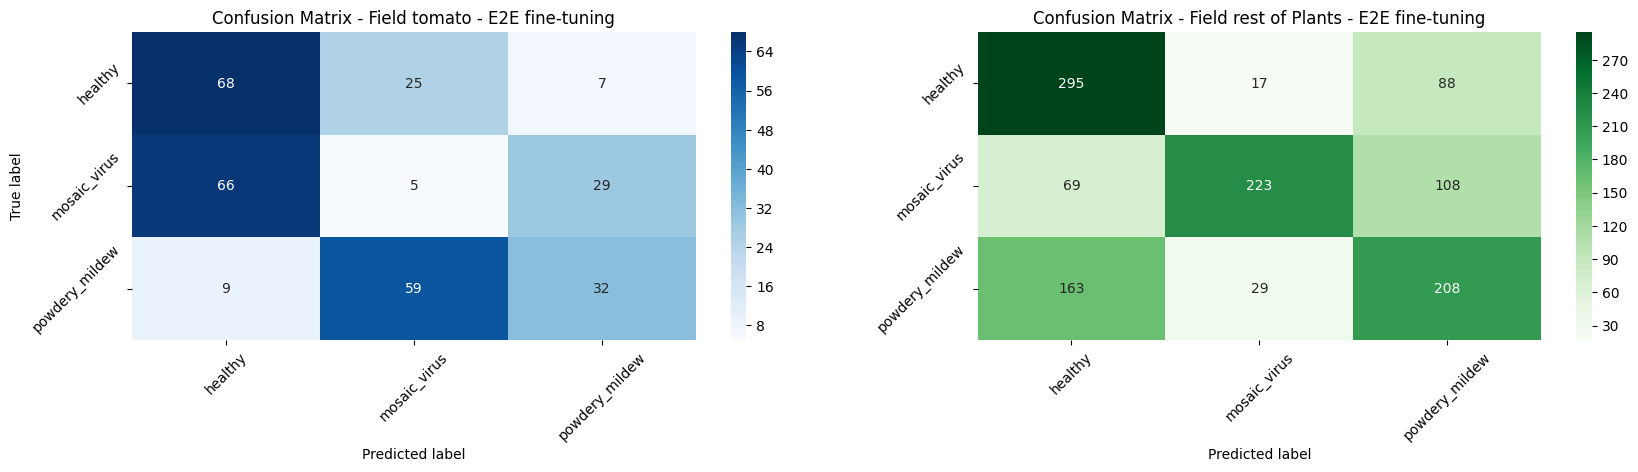

In [ ]:
# Generar matrices de confusión
cm_tomato_ft_e2e = confusion_matrix(y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e)
cm_species_ft_e2e = confusion_matrix(y_true_species_ft_e2e, y_pred_species_ft_e2e)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Matriz de confusión tomate
ax1 = sns.heatmap(cm_tomato_ft_e2e, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
colorbar1 = ax1.collections[0].colorbar
colorbar1.locator = MaxNLocator(integer=True)
colorbar1.update_ticks()
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_title("Confusion Matrix - Field tomato - E2E fine-tuning")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=45)

# Matriz de confusión resto de plantas
ax2 = sns.heatmap(cm_species_ft_e2e, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
colorbar2 = ax2.collections[0].colorbar
colorbar2.locator = MaxNLocator(integer=True)
colorbar2.update_ticks()
axes[1].set_xlabel("Predicted label")
axes[1].set_title("Confusion Matrix - Field rest of Plants - E2E fine-tuning")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=45)

# Guardar matriz de confusión
model_name_e2e="EfficientNetB0"
plt.savefig(os.path.join(RESULTS_PATH_no_seg, f"e2e_ft_cm_field_final_ex2_{model_name_e2e}.jpg"))

<font color="orange"><font size="3"> *Observar imágenes mal clasificadas*

In [ ]:
# Mostrar resultado de las primeras 15 imágenes
df_tomato_ft_e2e = build_results_table(test_generator_field_tomato_e2e, preds_tomato_ft_e2e, y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e, class_labels_tomato_ft_e2e, "e2e_ft", "CampoTomate", RESULTS_PATH_no_seg)
df_species_ft_e2e = build_results_table(test_generator_field_species_e2e, preds_species_ft_e2e, y_true_species_ft_e2e, y_pred_species_ft_e2e, class_labels_species_ft_e2e, "e2e_ft", "CampoEspecies", RESULTS_PATH_no_seg)


Resultados detallados - e2e_ft (CampoTomate):


Imagen Clase correcta  \
0   tomato_field_healthy_dataset04_image001.jpg        healthy   
1   tomato_field_healthy_dataset04_image002.jpg        healthy   
2   tomato_field_healthy_dataset04_image003.jpg        healthy   
3   tomato_field_healthy_dataset04_image004.jpg        healthy   
4   tomato_field_healthy_dataset04_image005.jpg        healthy   
5   tomato_field_healthy_dataset04_image006.jpg        healthy   
6   tomato_field_healthy_dataset04_image007.jpg        healthy   
7   tomato_field_healthy_dataset04_image008.jpg        healthy   
8   tomato_field_healthy_dataset04_image009.jpg        healthy   
9   tomato_field_healthy_dataset04_image010.jpg        healthy   
10  tomato_field_healthy_dataset04_image011.jpg        healthy   
11  tomato_field_healthy_dataset04_image012.jpg        healthy   
12  tomato_field_healthy_dataset04_image013.jpg        healthy   
13  tomato_field_healthy_dataset04_image014.jpg        healthy   
14  tomato_field_healthy_dataset04_image015.jpg        healthy   

    Clase predicha  Probabilidad Acierto  
0     mosaic_virus      0.608983      no  
1          healthy      0.591692      si  
2          healthy      0.630774      si  
3     mosaic_virus      0.557885      no  
4     mosaic_virus      0.466383      no  
5          healthy      0.806253      si  
6   powdery_mildew      0.498297      no  
7     mosaic_virus      0.952608      no  
8     mosaic_virus      0.996254      no  
9     mosaic_virus      0.947135      no  
10    mosaic_virus      0.960224      no  
11    mosaic_virus      0.940659      no  
12    mosaic_virus      0.825612      no  
13         healthy      0.741099      si  
14         healthy      0.528047      si


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/predicciones_e2e_ft_final_ex2_CampoTomate.csv

Resumen de aciertos por clase:


Acierto         no  si
Clase correcta        
healthy         32  68
mosaic_virus    95   5
powdery_mildew  68  32


Resultados detallados - e2e_ft (CampoEspecies):


Imagen Clase correcta  \
0   bell_pepper_field_healthy_dataset05_image001.jpg        healthy   
1   bell_pepper_field_healthy_dataset05_image002.jpg        healthy   
2   bell_pepper_field_healthy_dataset05_image003.jpg        healthy   
3   bell_pepper_field_healthy_dataset05_image004.jpg        healthy   
4   bell_pepper_field_healthy_dataset05_image005.jpg        healthy   
5   bell_pepper_field_healthy_dataset05_image006.jpg        healthy   
6   bell_pepper_field_healthy_dataset05_image007.jpg        healthy   
7   bell_pepper_field_healthy_dataset05_image008.jpg        healthy   
8   bell_pepper_field_healthy_dataset05_image009.jpg        healthy   
9   bell_pepper_field_healthy_dataset05_image010.jpg        healthy   
10  bell_pepper_field_healthy_dataset05_image011.jpg        healthy   
11  bell_pepper_field_healthy_dataset05_image012.jpg        healthy   
12  bell_pepper_field_healthy_dataset05_image013.jpg        healthy   
13  bell_pepper_field_healthy_dataset05_image014.jpg        healthy   
14  bell_pepper_field_healthy_dataset05_image015.jpg        healthy   

    Clase predicha  Probabilidad Acierto  
0          healthy      0.963112      si  
1          healthy      0.991346      si  
2          healthy      0.949705      si  
3          healthy      0.987569      si  
4          healthy      0.860694      si  
5          healthy      0.666057      si  
6          healthy      0.994508      si  
7          healthy      0.993676      si  
8          healthy      0.657296      si  
9   powdery_mildew      0.517416      no  
10         healthy      0.739784      si  
11         healthy      0.998709      si  
12         healthy      0.897013      si  
13  powdery_mildew      0.505405      no  
14  powdery_mildew      0.622583      no


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_no_seg/predicciones_e2e_ft_final_ex2_CampoEspecies.csv

Resumen de aciertos por clase:


Acierto          no   si
Clase correcta          
healthy         105  295
mosaic_virus    177  223
powdery_mildew  192  208

In [ ]:
# Mostrar imágenes mal clasificadas
mostrar_mal_clasificadas(test_generator_field_tomato_e2e, preds_tomato_ft_e2e, y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e, class_labels_tomato_ft_e2e, "e2e_ft", "CampoTomate", n_mostrar=15, RESULTS_PATH=RESULTS_PATH_no_seg)
mostrar_mal_clasificadas(test_generator_field_species_e2e, preds_species_ft_e2e, y_true_species_ft_e2e, y_pred_species_ft_e2e, class_labels_species_ft_e2e, "e2e_ft", "CampoEspecies", n_mostrar=15, RESULTS_PATH=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

### <font color="orange"><font size="4"> ***6.4.3.- Resultados Grad-CAM***

In [ ]:
# Ejemplo 1: evaluar grad-CAM sobre imagen de "healthy"
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/bell_pepper/field/healthy/bell_pepper_field_healthy_dataset05_image001.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/cucumber/field/healthy/cucumber_field_healthy_dataset21_image030.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/eggplant/field/healthy/eggplant_field_healthy_dataset16_image037.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/pumpkin/field/healthy/pumpkin_field_healthy_dataset08_image050.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/tomato/field/healthy/tomato_field_healthy_dataset04_image006.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/tomato/lab/healthy/tomato_lab_healthy_dataset01_image0086.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="healthy", save=True, results_path=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ejemplo 2: evaluar grad-CAM sobre imagen de "mosaic_virus"

gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/bell_pepper/field/mosaic_virus/bell_pepper_field_mosaic_virus_dataset07_image011.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/cucumber/field/mosaic_virus/cucumber_field_mosaic_virus_dataset24_image100.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/eggplant/field/mosaic_virus/eggplant_field_mosaic_virus_dataset16_image063.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/pumpkin/field/mosaic_virus/pumpkin_field_mosaic_virus_dataset08_image096.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/tomato/field/mosaic_virus/tomato_field_mosaic_virus_dataset11_image081.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/tomato/lab/mosaic_virus/tomato_lab_mosaic_virus_dataset25_image0012.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="mosaic_virus", save=True, results_path=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Ejemplo 3: evaluar grad-CAM sobre imagen de "powdery_mildew"

gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/bell_pepper/field/powdery_mildew/bell_pepper_field_powdery_mildew_dataset12_image015.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="bell_pepper", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/cucumber/field/powdery_mildew/cucumber_field_powdery_mildew_dataset22_image048.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="cucumber", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/eggplant/field/powdery_mildew/eggplant_field_powdery_mildew_dataset16_image018.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="eggplant", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/pumpkin/field/powdery_mildew/pumpkin_field_powdery_mildew_dataset03_image012.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="pumpkin", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/tomato/field/powdery_mildew/tomato_field_powdery_mildew_dataset04_image017.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)
gradcam_simple(model_ft_e2e, "/content/dataset_no_seg/tomato/lab/powdery_mildew/tomato_lab_powdery_mildew_dataset02_image0002.jpg",
               base_model_name="e2e_ft", last_conv_layer_name="conv5_block3_out", preprocess_func=preprocess_resnet50,
               planta="tomato-lab", enfermedad="powdery_mildew", save=True, results_path=RESULTS_PATH_no_seg)

Output hidden; open in https://colab.research.google.com to view.

# <font color="orange"><font size="7"> **7.- CONCLUSIONES**

<font color="orange"><font size="3"> *Resumen de métricas para el modelo ResNet50*

In [ ]:
# Crear lista de resultados
metricas_final = [
    resumen_metricas(y_true_test_RN, y_pred_test_RN, "ResNet50", "Lab-Seg"),
    resumen_metricas(y_true_RN_tomato, y_pred_RN_tomato, "ResNet50", "CampoTomate-Seg"),
    resumen_metricas(y_true_RN_species, y_pred_RN_species, "ResNet50", "CampoEspecies-Seg"),

    resumen_metricas(y_true_lab, y_pred_lab, "ResNet50", "Lab-Seg-Fine-tuning"),
    resumen_metricas(y_true_field_tomato, y_pred_field_tomato, "ResNet50", "CampoTomate-Seg-Fine-tuning"),
    resumen_metricas(y_true_field_species, y_pred_field_species, "ResNet50", "CampoEspecies-Seg-Fine-tuning"),

    resumen_metricas(y_true_test_e2e, y_pred_test_e2e, "ResNet50-e2e", "Lab-NoSeg"),
    resumen_metricas(y_true_tomato_e2e, y_pred_tomato_e2e, "ResNet50-e2e", "CampoTomate-NoSeg"),
    resumen_metricas(y_true_species_e2e, y_pred_species_e2e, "ResNet50-e2e", "CampoEspecies-NoSeg"),

    resumen_metricas(y_true_test_ft_e2e, y_pred_test_ft_e2e, "ResNet50-e2e", "Lab-NoSeg-Fine-tuning"),
    resumen_metricas(y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e, "ResNet50-e2e", "CampoTomate-NoSeg-Fine-tuning"),
    resumen_metricas(y_true_species_ft_e2e, y_pred_species_ft_e2e, "ResNet50-e2e", "CampoEspecies-NoSeg-Fine-tuning")]

# Convertir a DataFrame
df_metricas_final = pd.DataFrame(metricas_final)

# Aplicar formato solo a columnas numéricas
numeric_cols = df_metricas_final.select_dtypes(include=['number']).columns
display(df_metricas_final.style.background_gradient(cmap="YlGn").format({col: "{:.4f}" for col in numeric_cols}))

# Guardar resultados en formato CSV
output_path = os.path.join(RESULTS_PATH, "metricas_comparativas_final_de_todos_los_ResNet50_ex2.csv")
df_metricas_final.to_csv(output_path, index=False)
print(f"\nTabla guardada en: {output_path}")


Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/TFM/Modelo deep learning/results_seg/metricas_comparativas_final_de_todos_los_ResNet50_ex2.csv


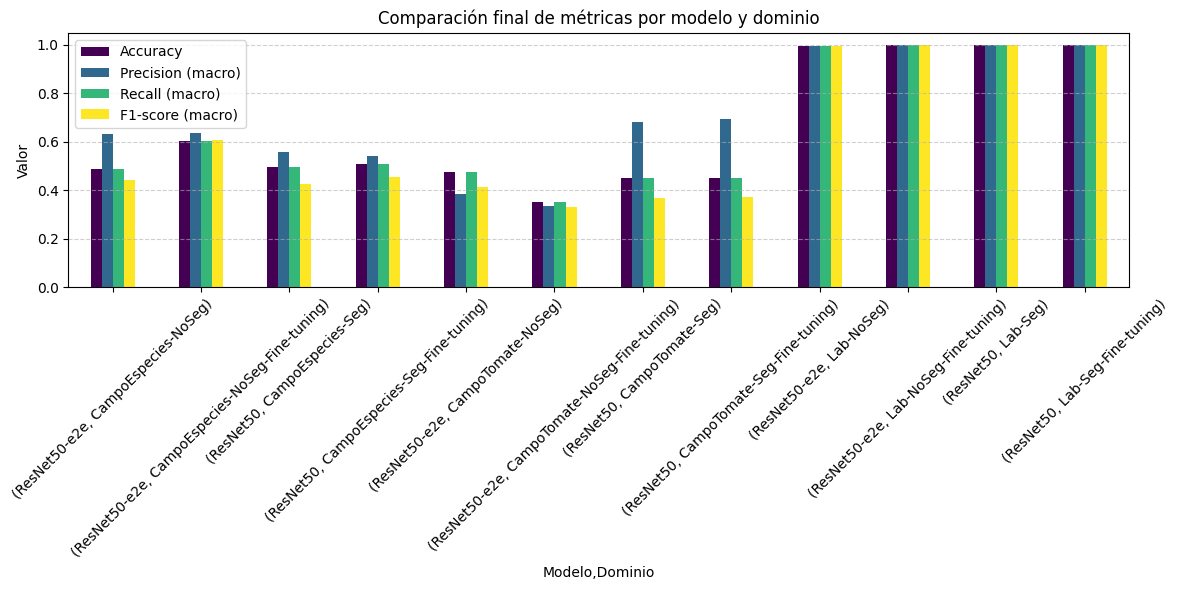

In [ ]:
# Ordenar métricas por dominio (lab vs field)
df_metricas_final = df_metricas_final.sort_values(["Dominio"]).reset_index(drop=True)

# Mostrar gráfico de barras y guardarlo
df_metricas_final.set_index(["Modelo", "Dominio"])[["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"]].plot(
    kind="bar", figsize=(12,6), rot=45, colormap="viridis")
plt.title("Comparación final de métricas por modelo y dominio")
plt.ylabel("Valor")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(os.path.join(RESULTS_PATH, "comparacion_metricas_todos-los-modelos_barplot_final_de_todos_los_ResNet50_ex2.jpg"))
plt.show()

<font color="orange"><font size="3"> *Matrices de confusión para el modelo ResNet50 con imágenes de campo de tomate*

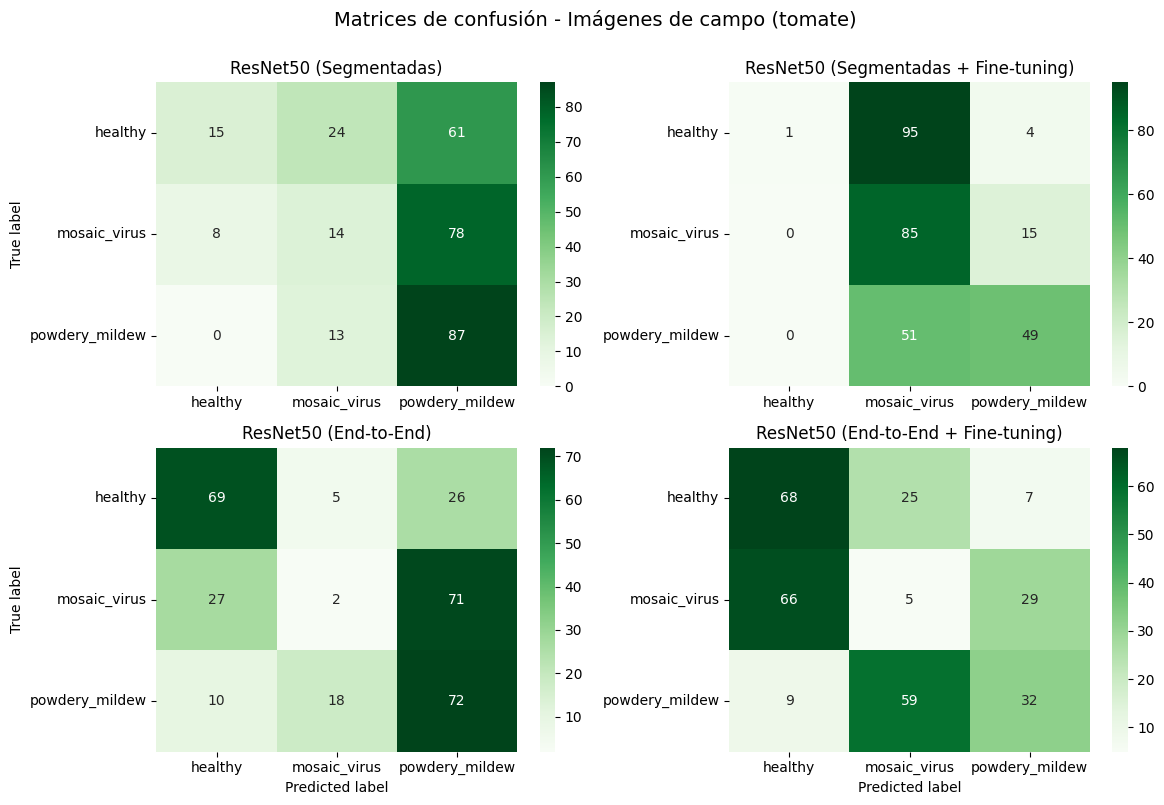

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# ResNet50 con segmentación
cm1 = confusion_matrix(y_true_MN_tomato, y_pred_MN_tomato)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0, 0])
axes[0, 0].set_title("ResNet50 (Segmentadas)", fontsize=12)
axes[0, 0].set_ylabel("True label")

# ResNet50 con segmentación + fine-tuning
cm2 = confusion_matrix(y_true_field_tomato, y_pred_field_tomato)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0, 1])
axes[0, 1].set_title("ResNet50 (Segmentadas + Fine-tuning)", fontsize=12)

# ResNet50 end-to-end
cm3 = confusion_matrix(y_true_tomato_e2e, y_pred_tomato_e2e)
sns.heatmap(cm3, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1, 0])
axes[1, 0].set_title("ResNet50 (End-to-End)", fontsize=12)
axes[1, 0].set_xlabel("Predicted label")
axes[1, 0].set_ylabel("True label")

# ResNet50 end-to-end + fine-tuning
cm4 = confusion_matrix(y_true_tomato_ft_e2e, y_pred_tomato_ft_e2e)
sns.heatmap(cm4, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1, 1])
axes[1, 1].set_title("ResNet50 (End-to-End + Fine-tuning)", fontsize=12)
axes[1, 1].set_xlabel("Predicted label")

plt.suptitle("Matrices de confusión - Imágenes de campo (tomate)", fontsize=14, y=1)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "comparison_confusion_matrices_field_tomate_todos_los_ResNet50_ex2.jpg"))
plt.show()

<font color="orange"><font size="3"> *Matrices de confusión para el modelo ResNet50 con imágenes de campo del resto de plantas*

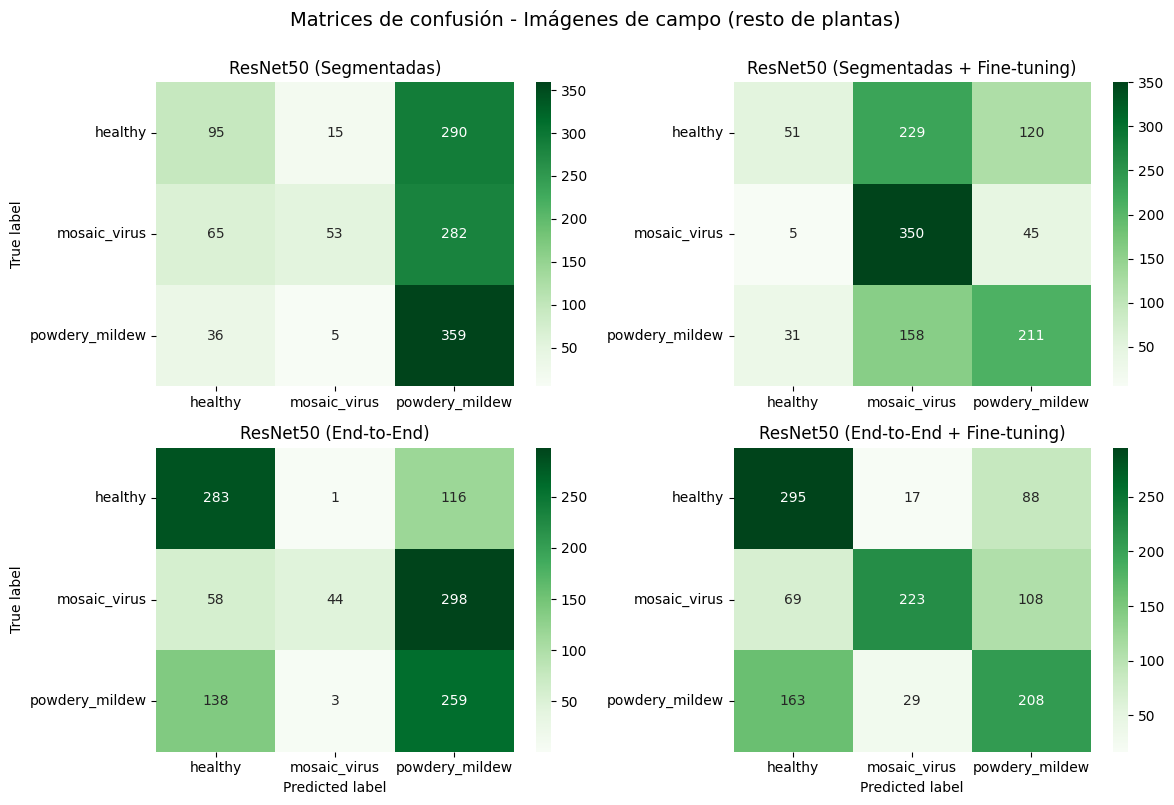

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# ResNet50 con segmentación
cm1 = confusion_matrix(y_true_MN_species, y_pred_MN_species)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0, 0])
axes[0, 0].set_title("ResNet50 (Segmentadas)", fontsize=12)
axes[0, 0].set_ylabel("True label")

# ResNet50 con segmentación + fine-tuning
cm2 = confusion_matrix(y_true_field_species, y_pred_field_species)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0, 1])
axes[0, 1].set_title("ResNet50 (Segmentadas + Fine-tuning)", fontsize=12)

# ResNet50 end-to-end
cm3 = confusion_matrix(y_true_species_e2e, y_pred_species_e2e)
sns.heatmap(cm3, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1, 0])
axes[1, 0].set_title("ResNet50 (End-to-End)", fontsize=12)
axes[1, 0].set_xlabel("Predicted label")
axes[1, 0].set_ylabel("True label")

# ResNet50 end-to-end + fine-tuning
cm4 = confusion_matrix(y_true_species_ft_e2e, y_pred_species_ft_e2e)
sns.heatmap(cm4, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1, 1])
axes[1, 1].set_title("ResNet50 (End-to-End + Fine-tuning)", fontsize=12)
axes[1, 1].set_xlabel("Predicted label")

plt.suptitle("Matrices de confusión - Imágenes de campo (resto de plantas)", fontsize=14, y=1)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "comparison_confusion_matrices_field_especies_todos_los_ResNet50_ex2.jpg"))
plt.show()

El mejor modelo es: end-to-end sin Fine-tuning para imágenes de campo de tomate, y end-to-end con Fine-tuning para las imágenes de campo del resto de plantas. Por tanto se puede decir que en este experimento PlantCV no aporta en la clasificación de las enfermedades.